In [1]:
# Libraries

import matplotlib
import numpy
import os
import platform
import shutil
import sys
import warnings

In [2]:
# Root directory

ROOT = os.getcwd()

while not ROOT.endswith('upolanc-thesis') :
	ROOT = os.path.abspath(os.path.join(ROOT, os.pardir))

	if len(ROOT) < len('upolanc-thesis') :
		if   platform.system() == 'Linux' :
			ROOT = '/d/hpc/home/up4472/workspace/upolanc-thesis'
		elif platform.system() == 'Windows' :
			ROOT = 'C:\\Developer\\Workspace\\PyCharm\\Projects\\upolanc-thesis'
		else :
			raise ValueError()

		print(f'Warning : could not find correct directory, using default : {ROOT}')
		break

if ROOT not in sys.path :
	sys.path.append(ROOT)

os.chdir(ROOT)

In [3]:
# Code

from source.python.data.feature import annodata as data_anndata
from source.python.io           import loader   as data_loader
from source.python.io           import writer   as data_writer

# 1. Setup

In [4]:
# Setup some directory paths

CWD = ROOT
OUT = os.path.join(CWD, 'output')
RES = os.path.join(CWD, 'resources')

OUT_DATA  = os.path.join(OUT,      'nbp02-anndata')
OUT_PLOT  = os.path.join(OUT_DATA, 'plot')
RES_NBP01 = os.path.join(OUT,      'nbp01-analysis')

shutil.rmtree(OUT_DATA, ignore_errors = True)

os.makedirs(OUT_DATA, exist_ok = True)
os.makedirs(OUT_PLOT, exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT_DATA}')
print(f'   Output Directory : {OUT_PLOT}')
print(f' Resource Directory : {RES_NBP01}')

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp02-anndata
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp02-anndata\plot
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp01-analysis


In [5]:
# Load the updated and synchronized data

tissue_metadata = data_loader.load_csv(
	filename = os.path.join(RES_NBP01, 'tissue-metadata.csv')
)

tissue_tpm = data_loader.load_csv(
	filename = os.path.join(RES_NBP01, 'tissue-tpm.csv')
)

In [6]:
# Define layer mapping

mapping = {
	'log1p'    : None,
	'boxcox1p' : None,
	'normal'   : 'boxcox1p',
	'standard' : 'boxcox1p'
}

data_writer.write_json(
	data     = mapping,
	filename = os.path.join(OUT_DATA, 'layer-mapping.json')
)

In [7]:
# Define percentile functions

def percentile90 (x, axis) : return numpy.percentile(x, 90, axis = axis)
def percentile75 (x, axis) : return numpy.percentile(x, 75, axis = axis)
def percentile60 (x, axis) : return numpy.percentile(x, 60, axis = axis)

functions = [
	('mean', numpy.mean),
	('p75',  percentile75),
	('max',  numpy.max),
	('std',  numpy.std),
	('min',  numpy.min)
]

In [8]:
# Define genes to boxplot

# AT2G17360.1 - expressive in all-to-most tissues
# AT2G07713.1 - expressive only in senescence
# AT4G08160.1 - expressive in all but dominant in single

genes = ['AT2G17360.1', 'AT2G07713.1', 'AT4G08160.1']

# 2. Anndata

In [9]:
# Create anndata object from the metadata and tpm tables

with warnings.catch_warnings() :
	warnings.simplefilter('ignore')

	anndata = data_anndata.create_anndata(
		mat = tissue_tpm,
		obs = tissue_metadata
	)

data_anndata.show_structure(anndata)

AnnData object with n_obs × n_vars = 4077 × 32711
    obs: 'Study', 'Control', 'Senescence', 'Age', 'Tissue', 'Group', 'Perturbation'


In [10]:
# Display anndata tpm matrix information

data_anndata.show_matrix(anndata, layer = None)

   Max value : 404,912.0
  Mean value :      28.8 ± 272.30584
Median value :       4.2
   Min value :       0.0

Total elements          : 133,362,747
Total elements =    0.0 :           0 [  0.00 %]
Total elements >    0.0 : 133,362,747 [100.00 %]
Total elements >    1.0 :  95,932,399 [ 71.93 %]
Total elements >   10.0 :  45,041,411 [ 33.77 %]
Total elements >   50.0 :  12,511,024 [  9.38 %]
Total elements >  100.0 :   6,147,393 [  4.61 %]
Total elements >  250.0 :   2,211,165 [  1.66 %]

[[ 17.954   2.140  11.186   0.000   0.815   0.865   7.954   0.001  115.884   3.965]
 [ 19.723   0.001   8.385   3.607   1.341   1.536   8.971   1.105  121.833   1.404]
 [ 30.892   0.502  10.543   0.001   0.484   0.678  11.866   1.070  136.181  11.309]
 [ 25.349   1.455  12.320   3.263   0.001   0.655   9.906   0.226  139.984   7.541]
 [ 29.913   2.084   9.219   0.622   0.871   1.533   4.785   7.057  158.566   0.001]]


# 3. Log

In [11]:
# Compute and save the log1p tpm values

anndata = data_anndata.compute_log1p(
	data       = anndata,
	layer      = mapping['log1p'],
	base       = 2,
	store_into = 'log1p'
)

In [12]:
# Display anndata log1p tpm matrix information

data_anndata.show_matrix(anndata, layer = 'log1p')

   Max value :  18.62725
  Mean value :   2.65670 ± 2.15060
Median value :   2.37071
   Min value :   0.00000

Total elements        : 133,362,747
Total elements =  0.0 :           0 [  0.00 %]
Total elements >  0.0 : 133,362,747 [100.00 %]
Total elements >  1.0 :  95,932,399 [ 71.93 %]
Total elements >  3.0 :  54,006,872 [ 40.50 %]
Total elements >  5.0 :  19,630,133 [ 14.72 %]
Total elements >  7.0 :   4,759,079 [  3.57 %]
Total elements >  9.0 :     899,212 [  0.67 %]

[[  4.244   1.651   3.607   0.000   0.860   0.899   3.162   0.001   6.869   2.312]
 [  4.373   0.001   3.230   2.204   1.227   1.343   3.318   1.074   6.941   1.266]
 [  4.995   0.586   3.529   0.001   0.570   0.746   3.685   1.050   7.100   3.622]
 [  4.720   1.296   3.736   2.092   0.001   0.727   3.447   0.293   7.139   3.094]
 [  4.950   1.625   3.353   0.698   0.904   1.341   2.532   3.010   7.318   0.001]]


## 3.1 Distribution

Function : numpy.mean
Genes below 10th percentile [   0.623310] :  3,271
Genes below 30th percentile [   1.394035] :  9,813
Genes above 70th percentile [   3.499221] :  9,813
Genes above 90th percentile [   5.144085] :  3,271



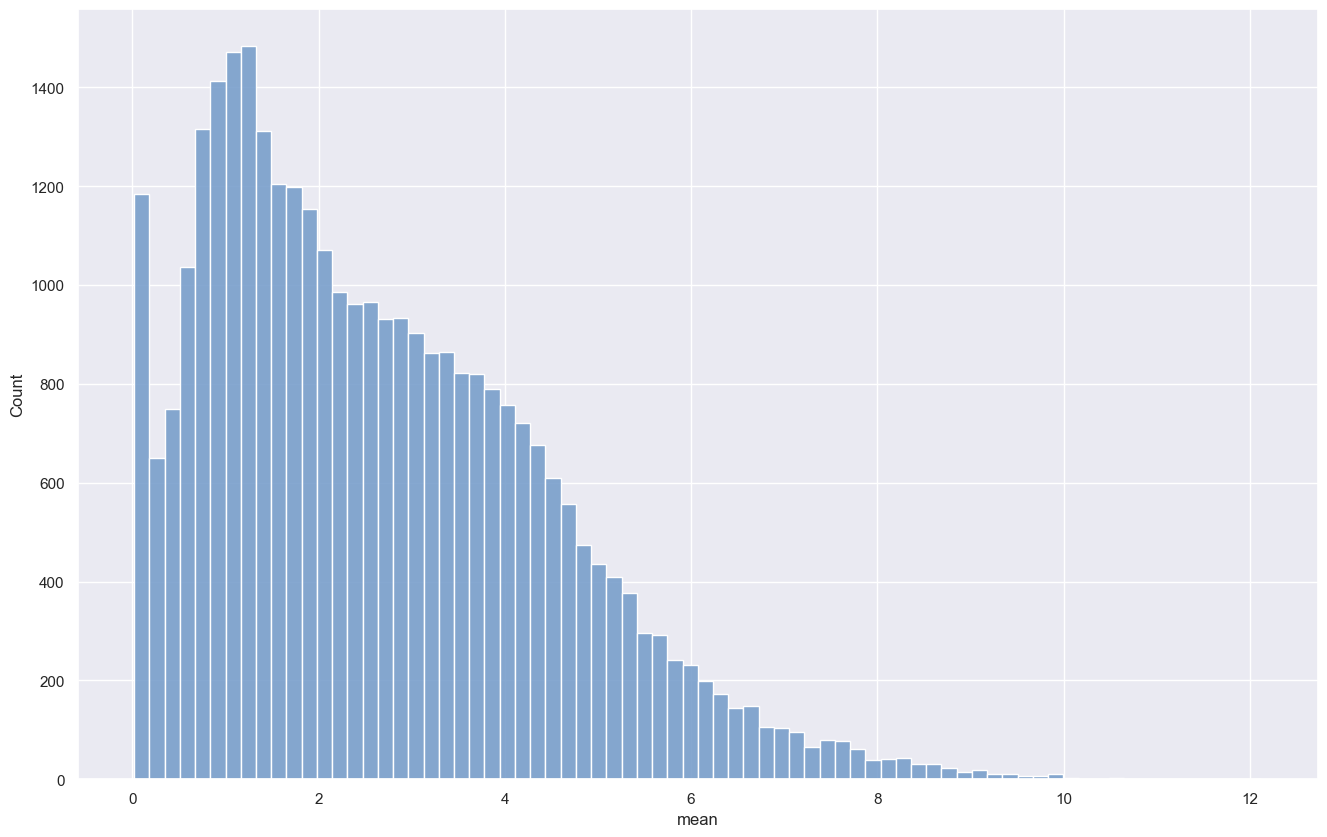

Function : __main__.percentile75
Genes below 10th percentile [   0.909943] :  3,271
Genes below 30th percentile [   2.045366] :  9,813
Genes above 70th percentile [   4.325415] :  9,813
Genes above 90th percentile [   5.982658] :  3,271



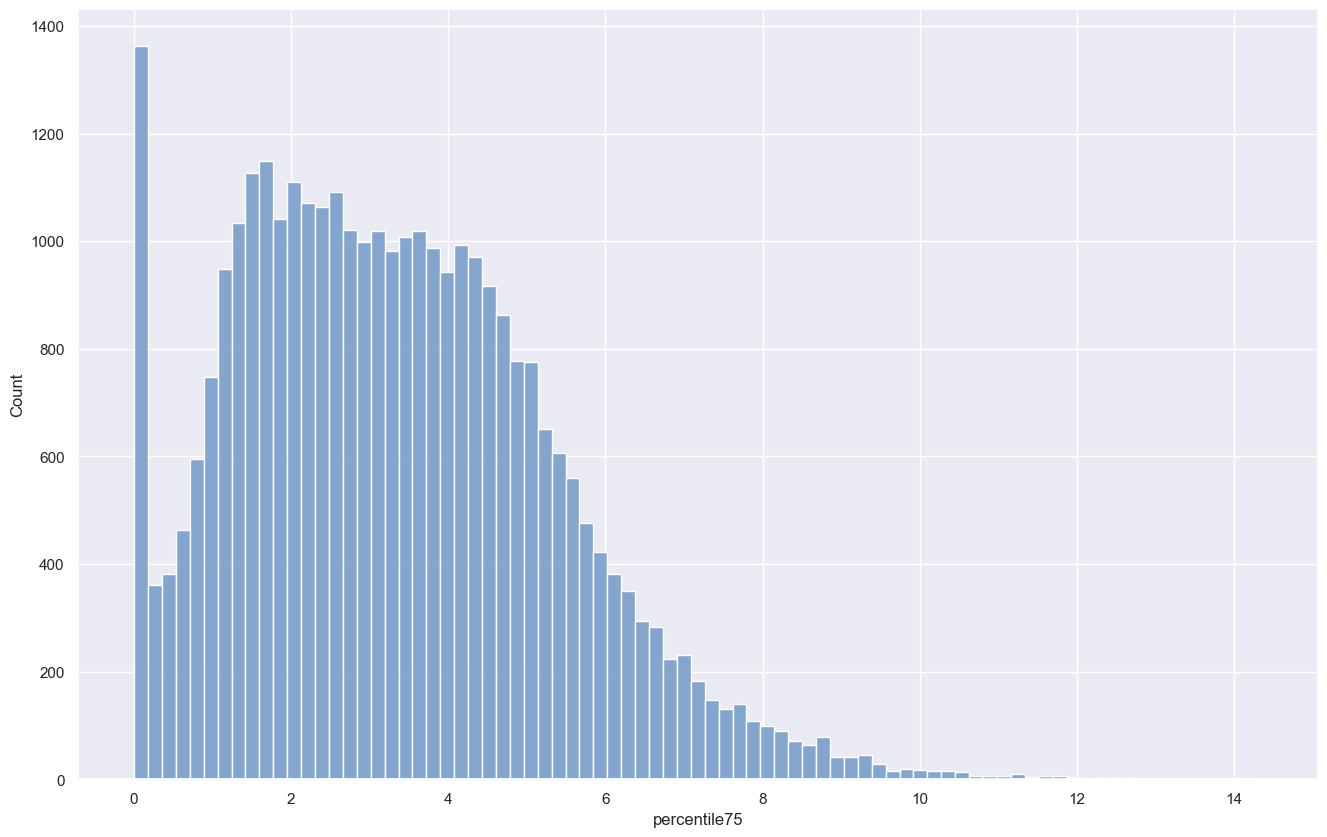

Function : numpy.amax
Genes below 10th percentile [   3.963604] :  3,271
Genes below 30th percentile [   5.256452] :  9,813
Genes above 70th percentile [   7.467051] :  9,813
Genes above 90th percentile [   9.544737] :  3,271



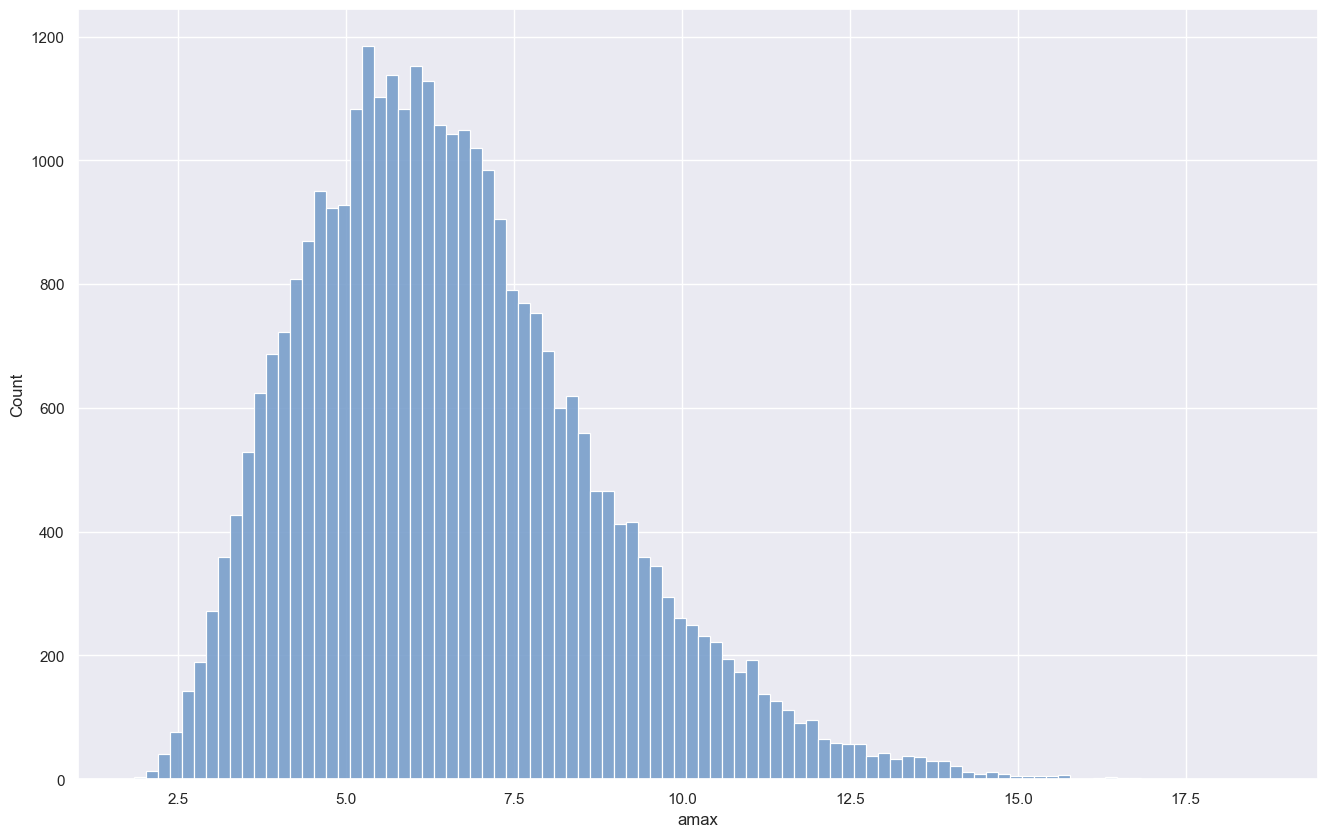

Function : numpy.std
Genes below 10th percentile [   0.609310] :  3,271
Genes below 30th percentile [   0.787811] :  9,813
Genes above 70th percentile [   1.177540] :  9,813
Genes above 90th percentile [   1.679106] :  3,271



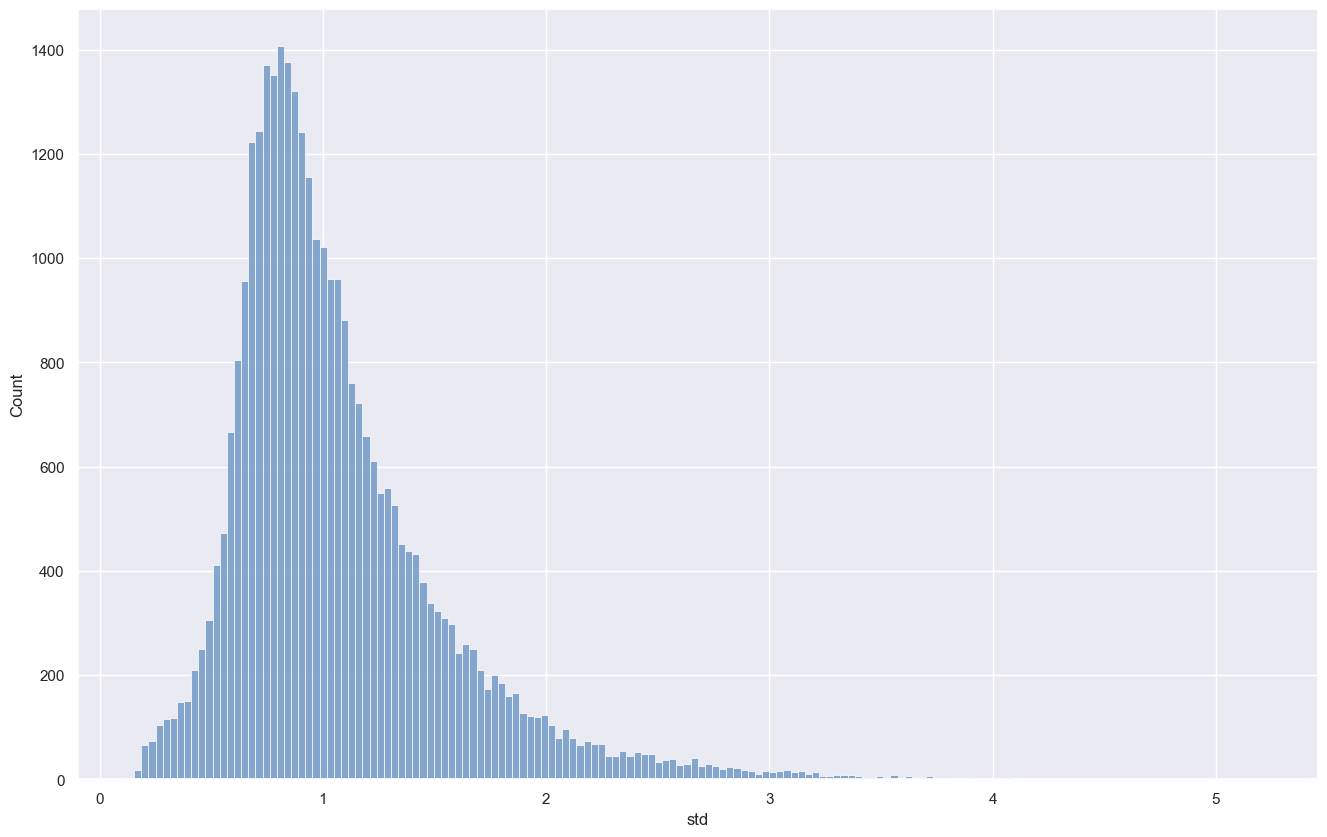

In [13]:
# Display log1p tpm value distribution per gene

for name, function in functions :
	if name == 'min' : continue

	data_anndata.tpm_histplot(
		data     = anndata,
		layer    = 'log1p',
		function = function,
		filters  = None,
		filename = os.path.join(OUT_PLOT, 'distribution-log1p-' + name)
	)

	matplotlib.pyplot.show()

## 3.2 Genes

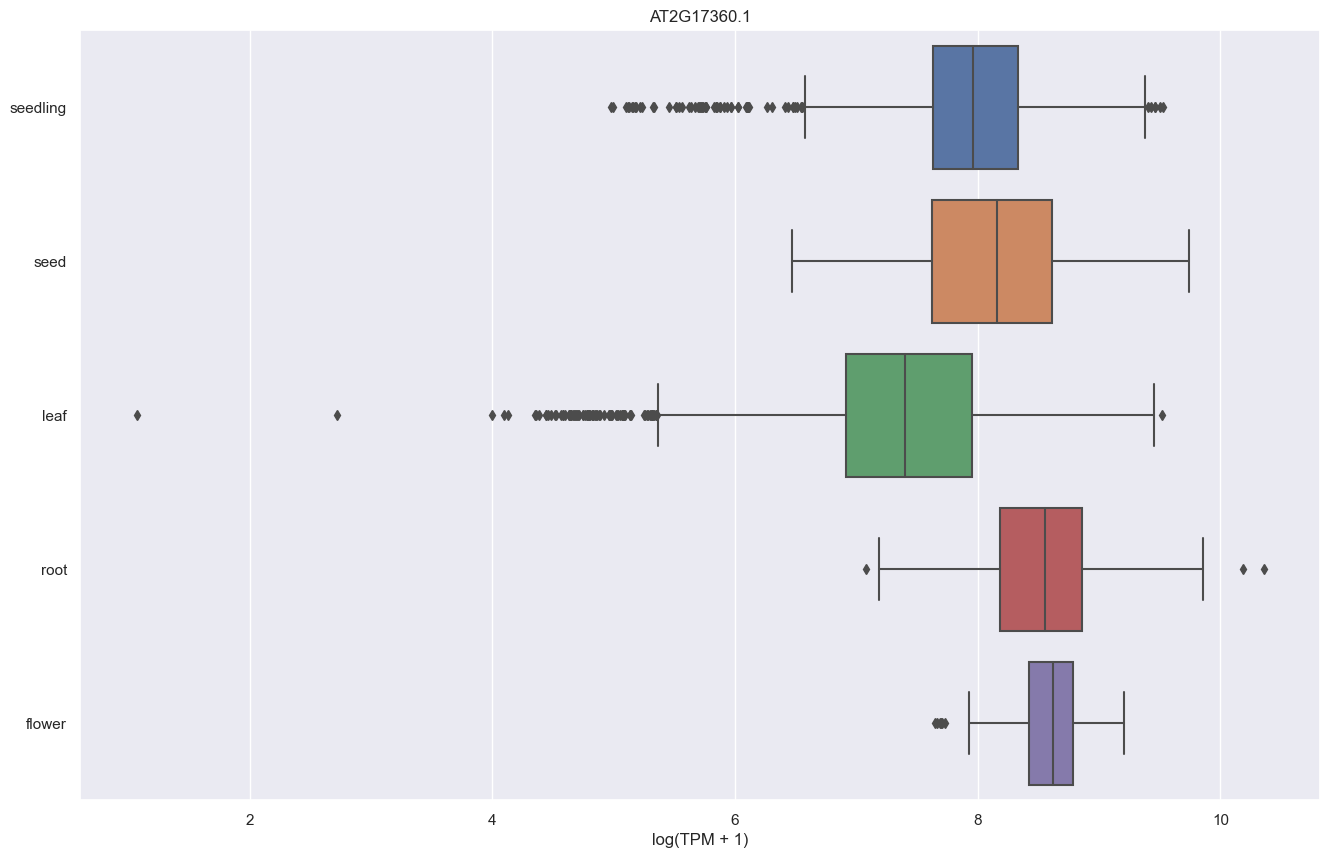

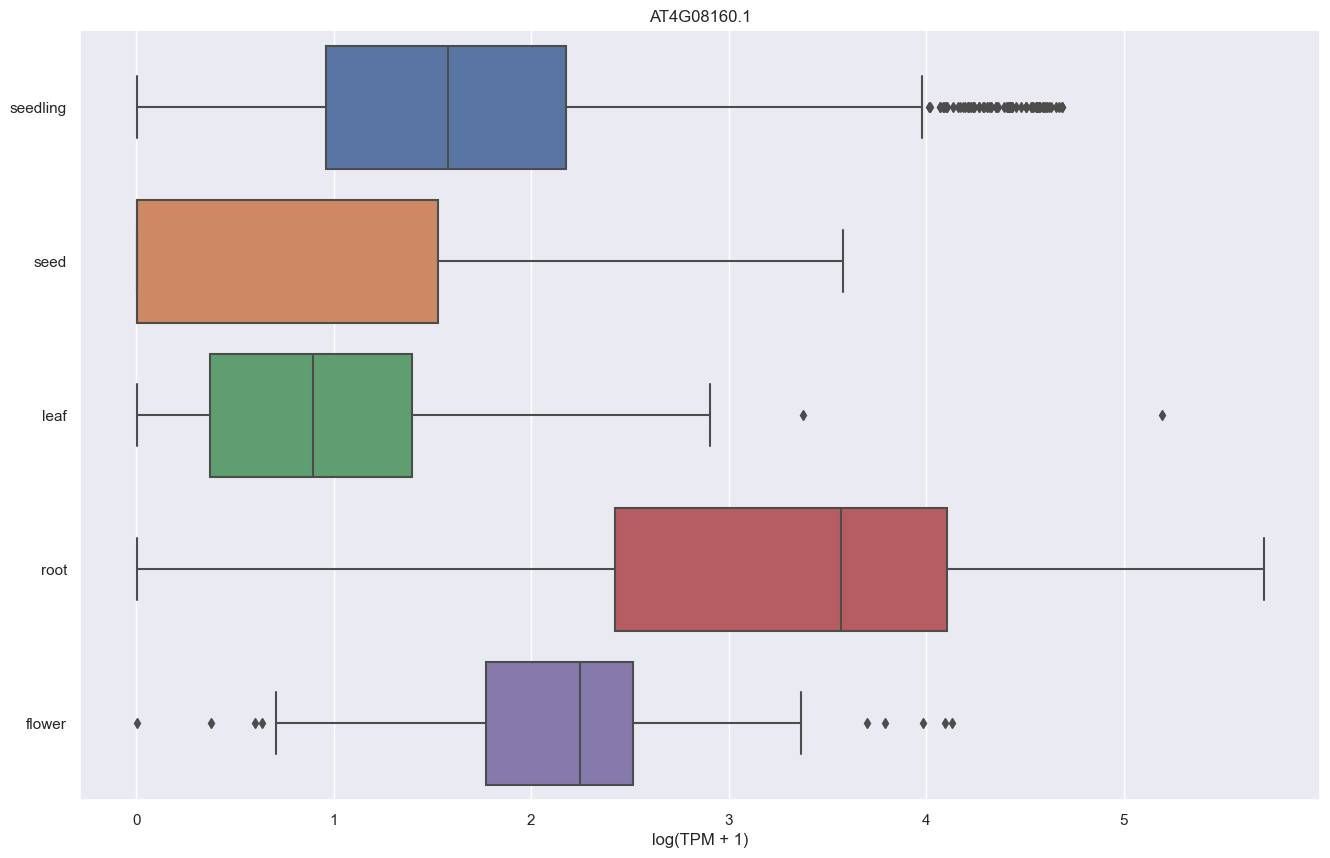

In [14]:
# Display an example of few gene expressions per tissue

for gene in genes :
	if gene not in anndata.var.index : continue

	data_anndata.gene_boxplot(
		data     = anndata,
		gene     = gene,
		groupby  = 'Tissue',
		layer    = 'log1p',
		filename = os.path.join(OUT_PLOT, 'tissue-log1p-' + gene)
	)

	matplotlib.pyplot.show()

In [15]:
# Display an example of a tissue-specific expressive gene <AT2G07713.1>

gene = 'AT2G07713.1'

if gene in anndata.var.index :
	data_anndata.gene_boxplot(
		data     = anndata,
		gene     = gene,
		groupby  = 'Tissue',
		layer    = 'log1p',
		filename = os.path.join(OUT_PLOT, 'tissue-log1p-' + gene)
	)

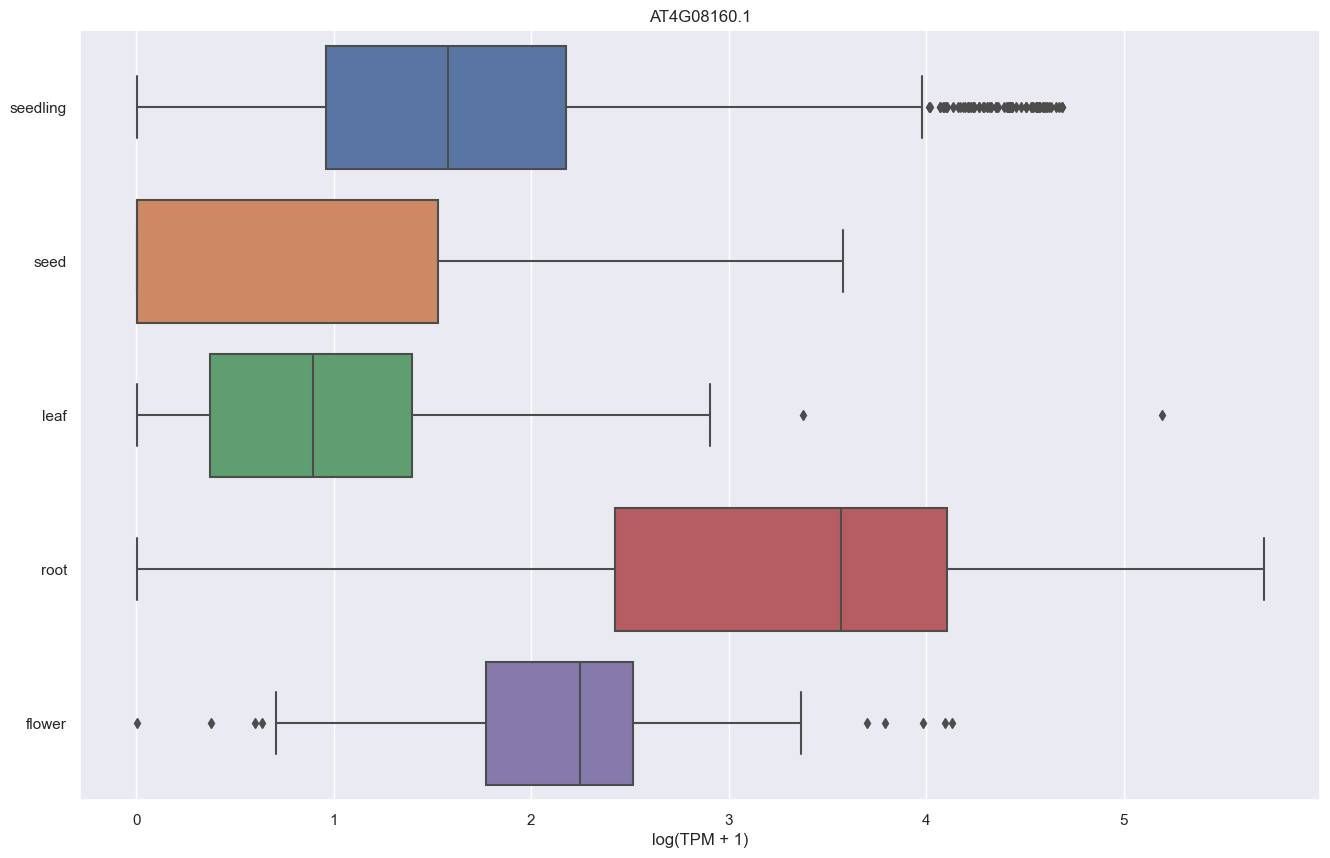

In [16]:
# Display an example of a tissue-prevelant expressive gene <AT4G08160.1>

gene = 'AT4G08160.1'

if gene in anndata.var.index :
	data_anndata.gene_boxplot(
		data     = anndata,
		gene     = gene,
		groupby  = 'Tissue',
		layer    = 'log1p',
		filename = os.path.join(OUT_PLOT, 'tissue-log1p-' + gene)
	)

# 4. BoxCox

In [17]:
# Compute and save the boxcox1p tpm values

anndata, factors = data_anndata.compute_boxcox1p(
	data       = anndata,
	store_into = 'boxcox1p',
	layer      = mapping['boxcox1p'],
	eps        = 1.0
)

print('Lambda : {}'.format(factors['lambda']))

Lambda : -0.22051877520199073


In [18]:
# Save boxcox factors

data_writer.write_json(
	data     = factors,
	filename = os.path.join(OUT_DATA, 'factors-boxcox.json')
)

In [19]:
# Display anndata boxcox1p tpm matrix information

data_anndata.show_matrix(anndata, layer = 'boxcox1p')

   Max value :   4.27172
  Mean value :   1.35919 ± 0.93868
Median value :   1.37845
   Min value :   0.00000

Total elements        : 133,362,747
Total elements =  0.0 :           0 [  0.00 %]
Total elements >  0.0 : 133,362,747 [100.00 %]
Total elements >  1.0 :  82,229,586 [ 61.66 %]
Total elements >  2.0 :  38,523,482 [ 28.89 %]
Total elements >  3.0 :   4,451,197 [  3.34 %]
Total elements >  4.0 :       4,126 [  0.00 %]

[[  2.164   1.011   1.922   0.000   0.559   0.582   1.738   0.001   2.948   1.350]
 [  2.211   0.001   1.767   1.297   0.776   0.841   1.804   0.686   2.965   0.798]
 [  2.421   0.389   1.891   0.001   0.378   0.489   1.953   0.672   3.003   1.928]
 [  2.331   0.815   1.973   1.241   0.001   0.477   1.857   0.199   3.012   1.709]
 [  2.407   0.997   1.819   0.459   0.585   0.841   1.455   1.672   3.053   0.001]]


## 4.1 Distribution

Function : numpy.mean
Genes below 10th percentile [   0.384200] :  3,271
Genes below 30th percentile [   0.818423] :  9,813
Genes above 70th percentile [   1.830719] :  9,813
Genes above 90th percentile [   2.426870] :  3,271



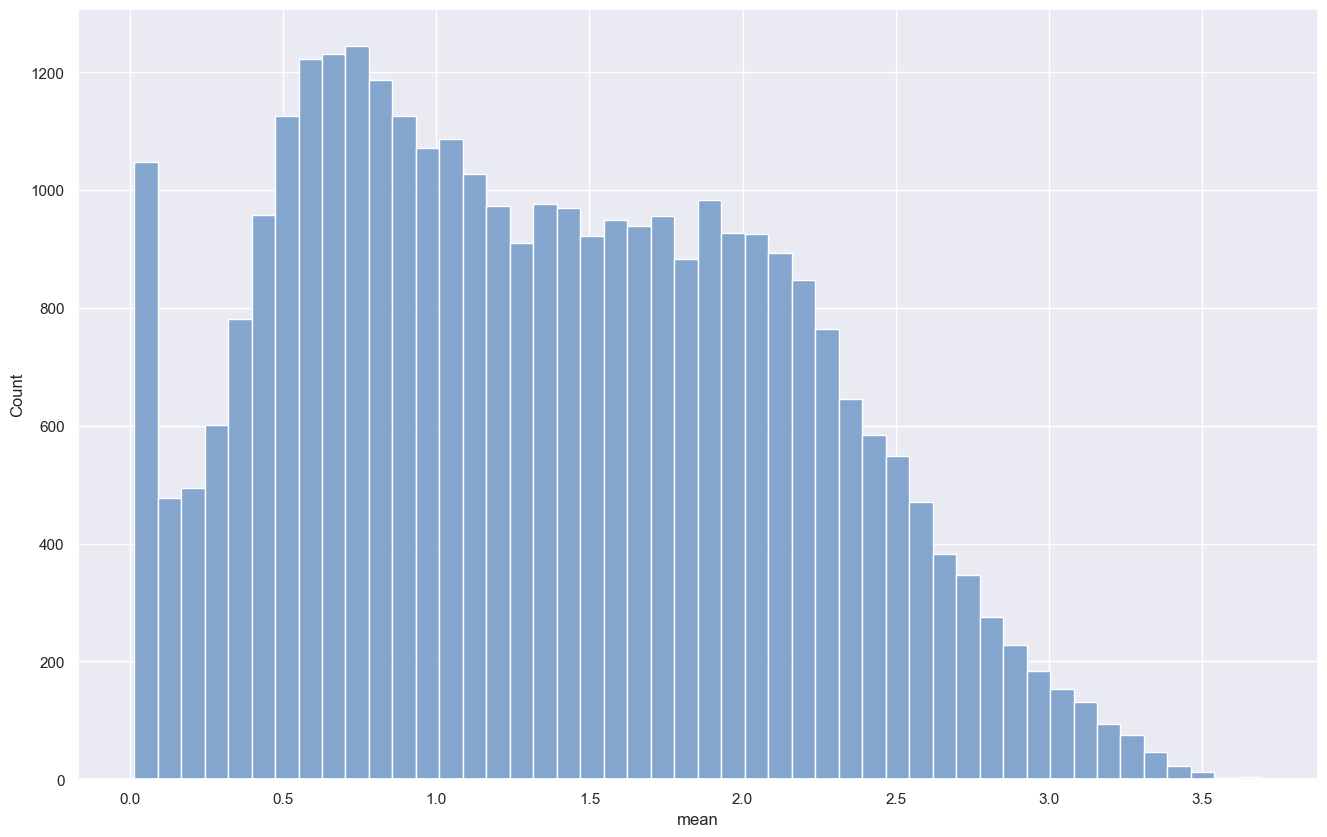

Function : __main__.percentile75
Genes below 10th percentile [   0.588826] :  3,271
Genes below 30th percentile [   1.217518] :  9,813
Genes above 70th percentile [   2.193654] :  9,813
Genes above 90th percentile [   2.717535] :  3,271



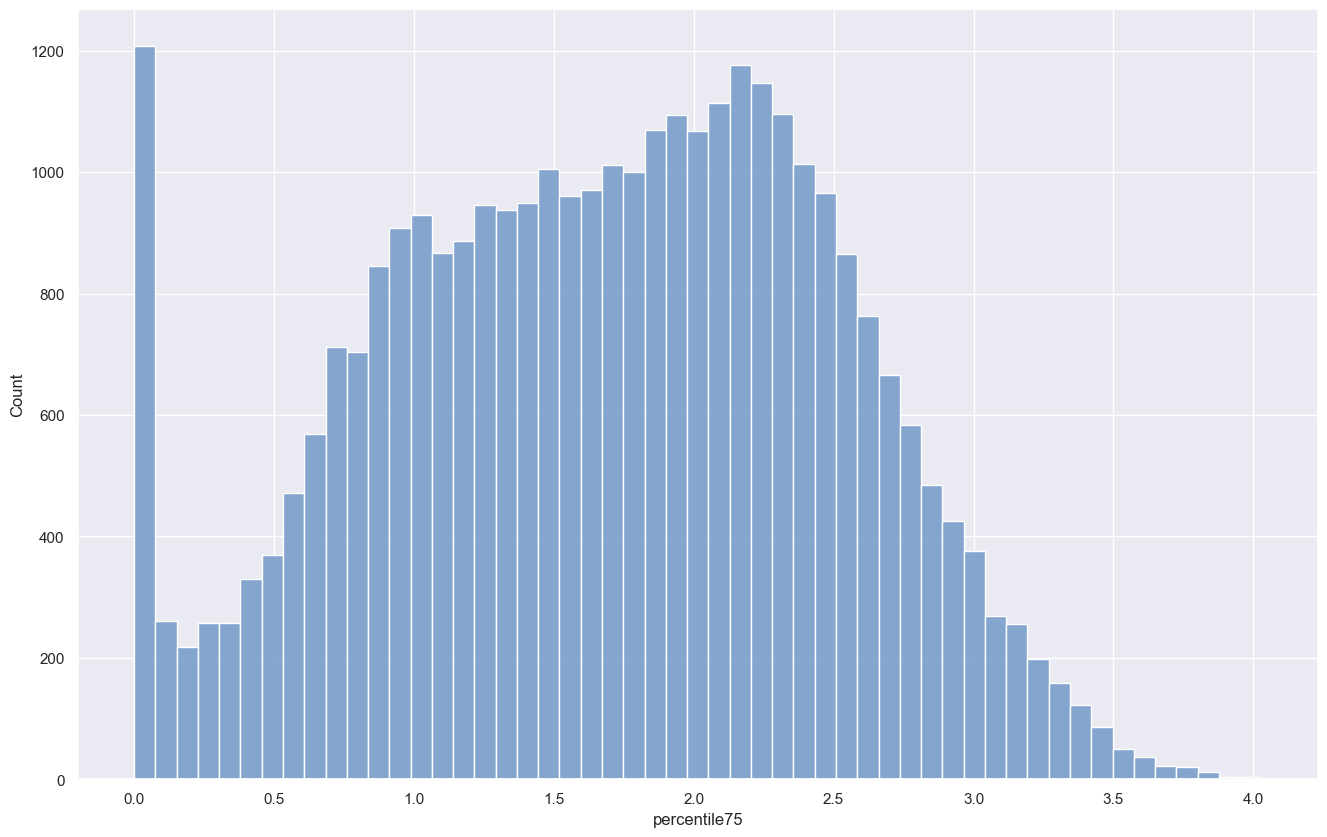

Function : numpy.amax
Genes below 10th percentile [   2.060535] :  3,271
Genes below 30th percentile [   2.504198] :  9,813
Genes above 70th percentile [   3.086420] :  9,813
Genes above 90th percentile [   3.480500] :  3,271



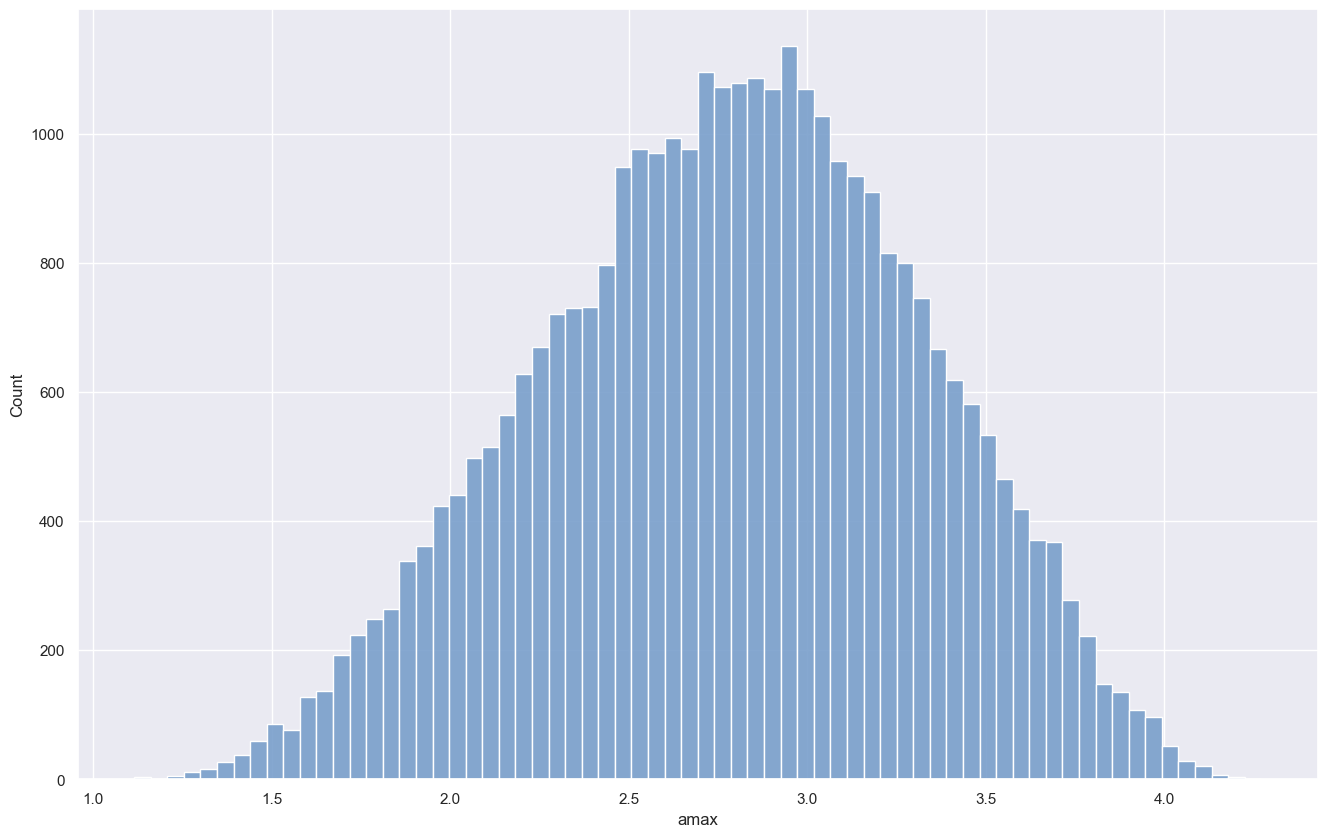

Function : numpy.std
Genes below 10th percentile [   0.277542] :  3,271
Genes below 30th percentile [   0.364513] :  9,813
Genes above 70th percentile [   0.554050] :  9,813
Genes above 90th percentile [   0.757086] :  3,271



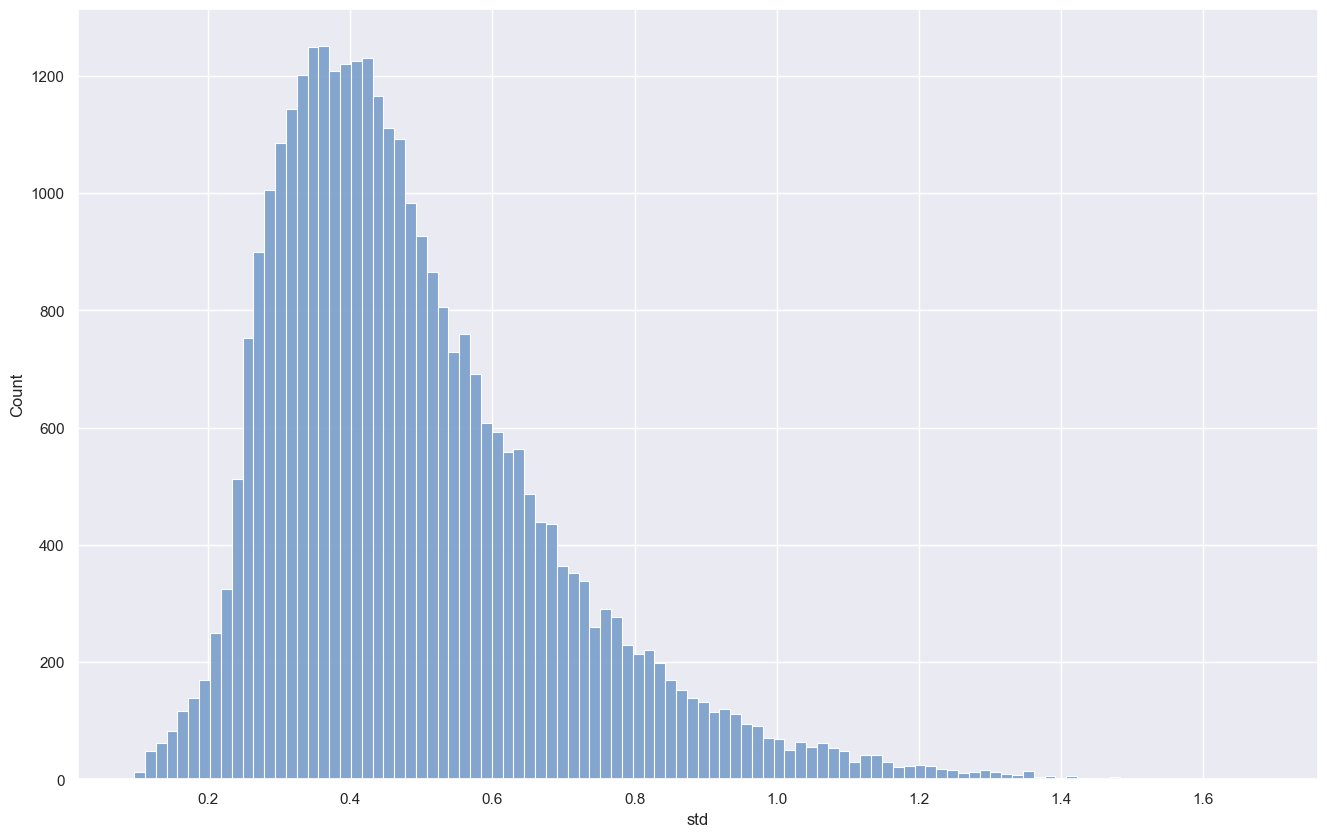

In [20]:
# Display boxcox1p tpm value distribution per gene

for name, function in functions :
	if name == 'min' : continue

	data_anndata.tpm_histplot(
		data     = anndata,
		layer    = 'boxcox1p',
		function = function,
		filters  = None,
		filename = os.path.join(OUT_PLOT, 'distribution-boxcox1p-' + name)
	)

	matplotlib.pyplot.show()

## 4.2 Genes

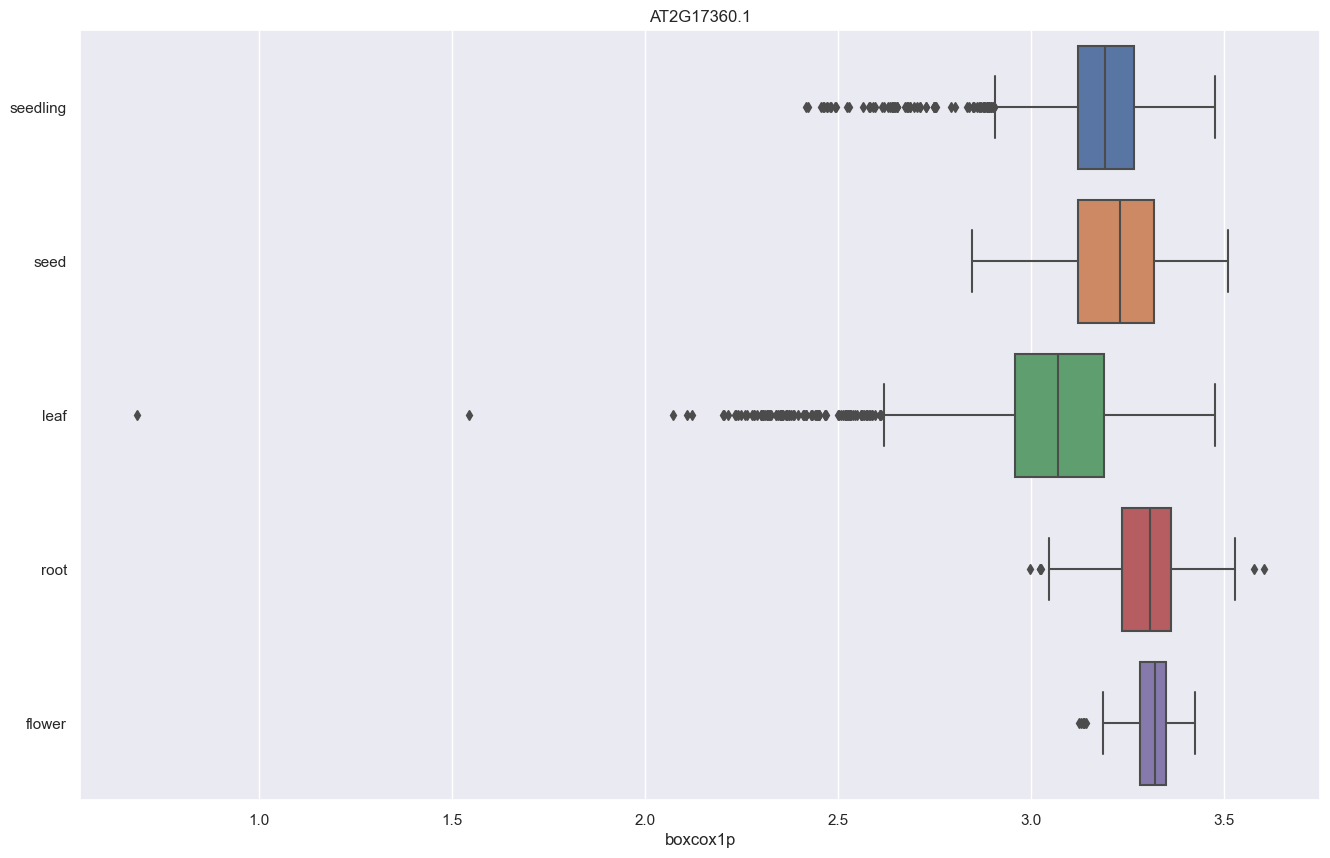

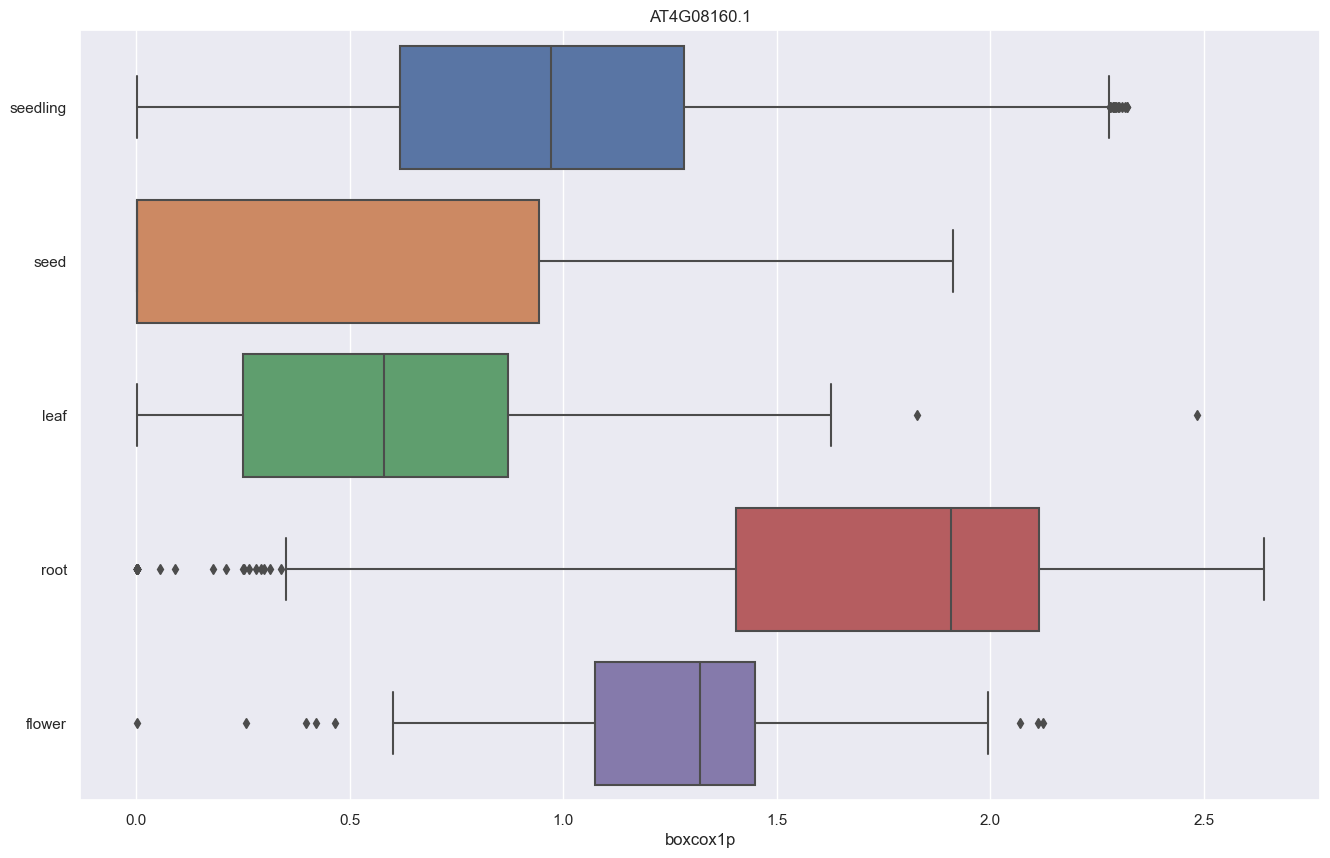

In [21]:
# Display an example of few gene expressions per tissue

for gene in genes :
	if gene not in anndata.var.index : continue

	data_anndata.gene_boxplot(
		data     = anndata,
		gene     = gene,
		groupby  = 'Tissue',
		layer    = 'boxcox1p',
		filename = os.path.join(OUT_PLOT, 'tissue-boxcox1p-' + gene)
	)

	matplotlib.pyplot.show()

# 5. Normal

In [22]:
# Compute and save the normalized tpm values

anndata, factors = data_anndata.compute_normalized(
	data       = anndata,
	layer      = mapping['normal'],
	store_into = 'normal'
)

print('Min : {}'.format(factors['min']))
print('Max : {}'.format(factors['max']))

Min : 6.312229818675851e-12
Max : 4.271718785525441


In [23]:
# Save boxcox factors

data_writer.write_json(
	data     = factors,
	filename = os.path.join(OUT_DATA, 'factors-normal.json')
)

In [24]:
# Display normalized log1p tpm matrix information

data_anndata.show_matrix(anndata, layer = 'normal')

   Max value :   1.00000
  Mean value :   0.31818 ± 0.21974
Median value :   0.32269
   Min value :   0.00000

Total elements        : 133,362,747
Total elements =  0.0 :           1 [  0.00 %]
Total elements >  0.0 : 133,362,746 [100.00 %]
Total elements >  0.1 : 103,587,740 [ 77.67 %]
Total elements >  0.3 :  70,764,152 [ 53.06 %]
Total elements >  0.5 :  32,116,317 [ 24.08 %]
Total elements >  0.7 :   4,595,010 [  3.45 %]

[[  0.507   0.237   0.450   0.000   0.131   0.136   0.407   0.000   0.690   0.316]
 [  0.518   0.000   0.414   0.304   0.182   0.197   0.422   0.161   0.694   0.187]
 [  0.567   0.091   0.443   0.000   0.089   0.114   0.457   0.157   0.703   0.451]
 [  0.546   0.191   0.462   0.291   0.000   0.112   0.435   0.047   0.705   0.400]
 [  0.563   0.233   0.426   0.107   0.137   0.197   0.341   0.391   0.715   0.000]]


## 5.1 Distribution

Function : numpy.mean
Genes below 10th percentile [   0.089940] :  3,271
Genes below 30th percentile [   0.191591] :  9,813
Genes above 70th percentile [   0.428567] :  9,813
Genes above 90th percentile [   0.568125] :  3,271



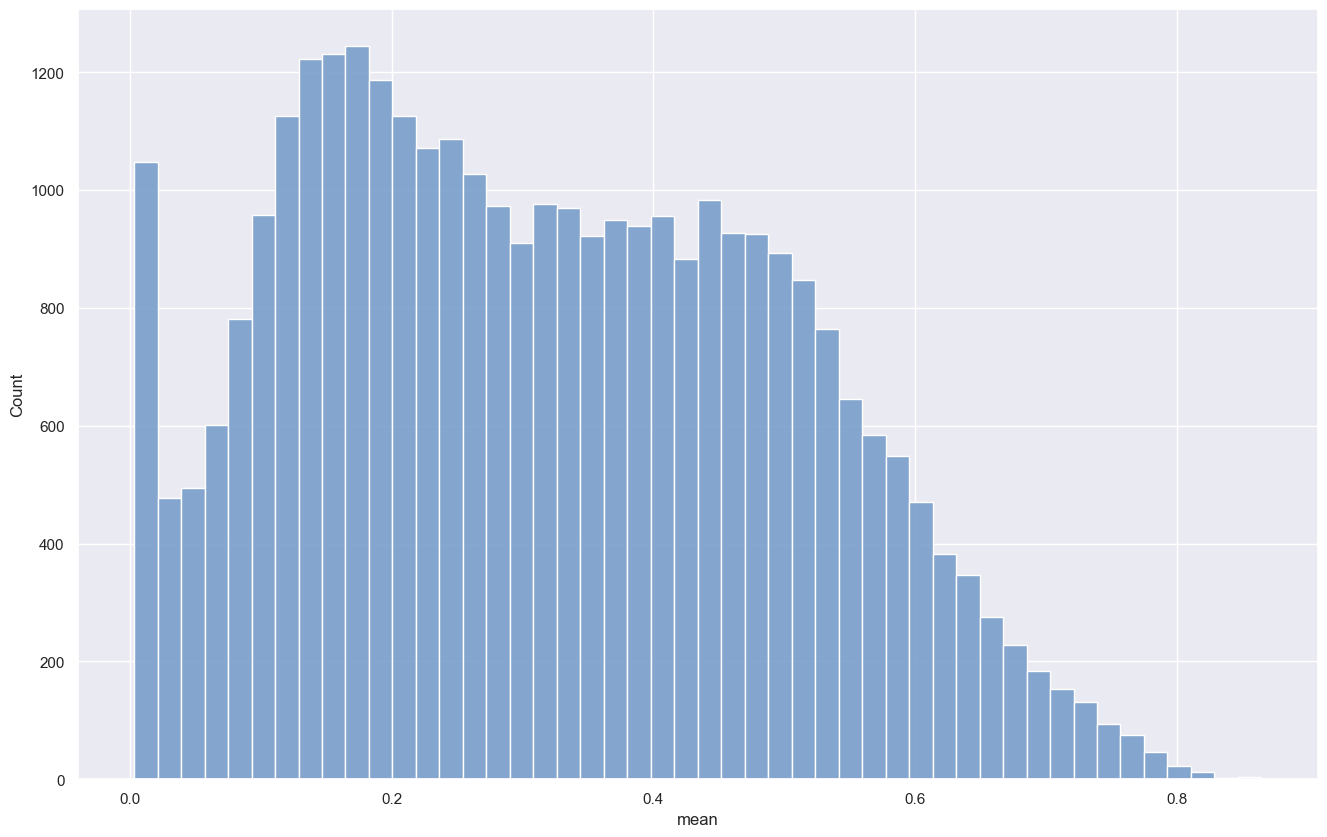

Function : __main__.percentile75
Genes below 10th percentile [   0.137843] :  3,271
Genes below 30th percentile [   0.285018] :  9,813
Genes above 70th percentile [   0.513529] :  9,813
Genes above 90th percentile [   0.636169] :  3,271



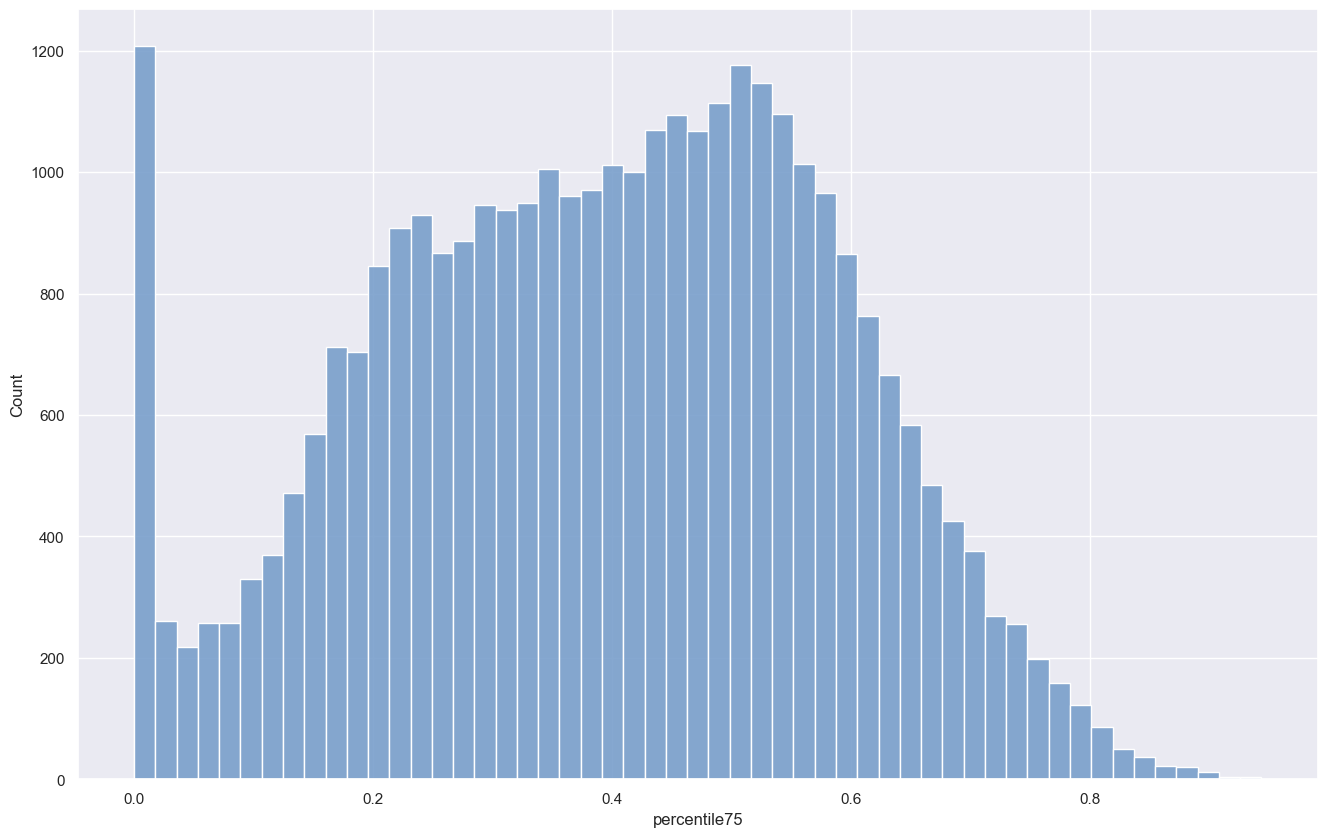

Function : numpy.amax
Genes below 10th percentile [   0.482367] :  3,271
Genes below 30th percentile [   0.586227] :  9,813
Genes above 70th percentile [   0.722524] :  9,813
Genes above 90th percentile [   0.814777] :  3,271



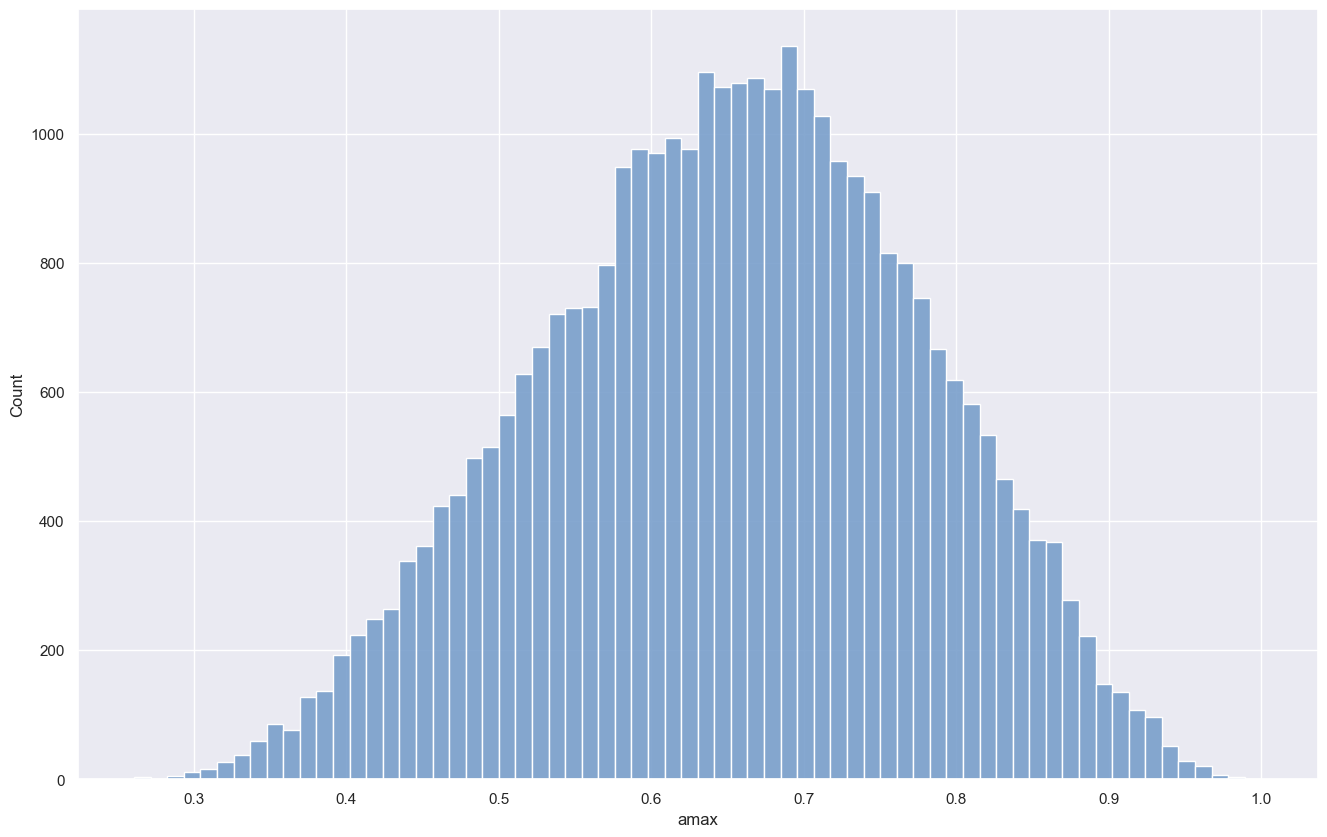

Function : numpy.std
Genes below 10th percentile [   0.064972] :  3,271
Genes below 30th percentile [   0.085332] :  9,813
Genes above 70th percentile [   0.129702] :  9,813
Genes above 90th percentile [   0.177232] :  3,271



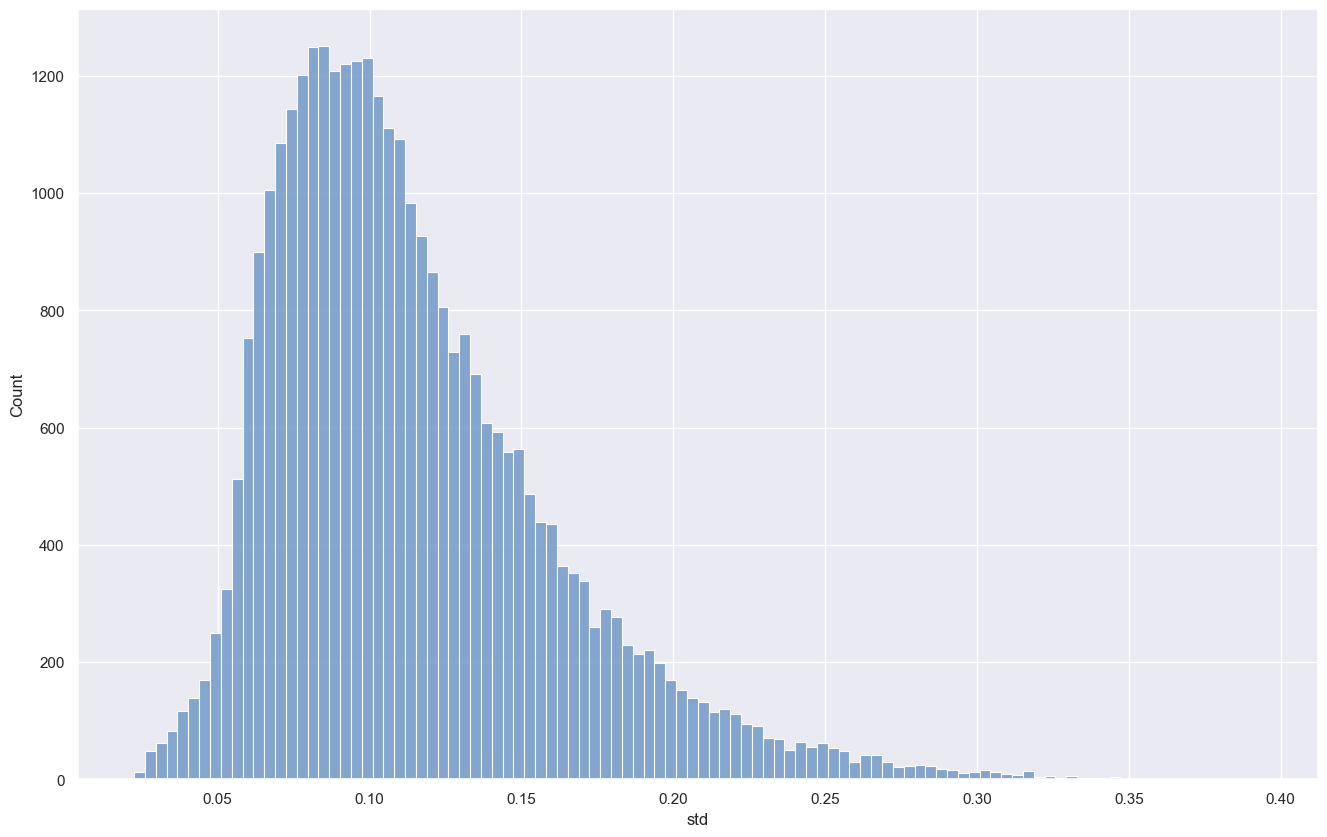

In [25]:
# Display normal tpm value distribution per gene

for name, function in functions :
	if name == 'min' : continue

	data_anndata.tpm_histplot(
		data     = anndata,
		layer    = 'normal',
		function = function,
		filters  = None,
		filename = os.path.join(OUT_PLOT, 'distribution-nornal-' + name)
	)

	matplotlib.pyplot.show()

## 5.2 Genes

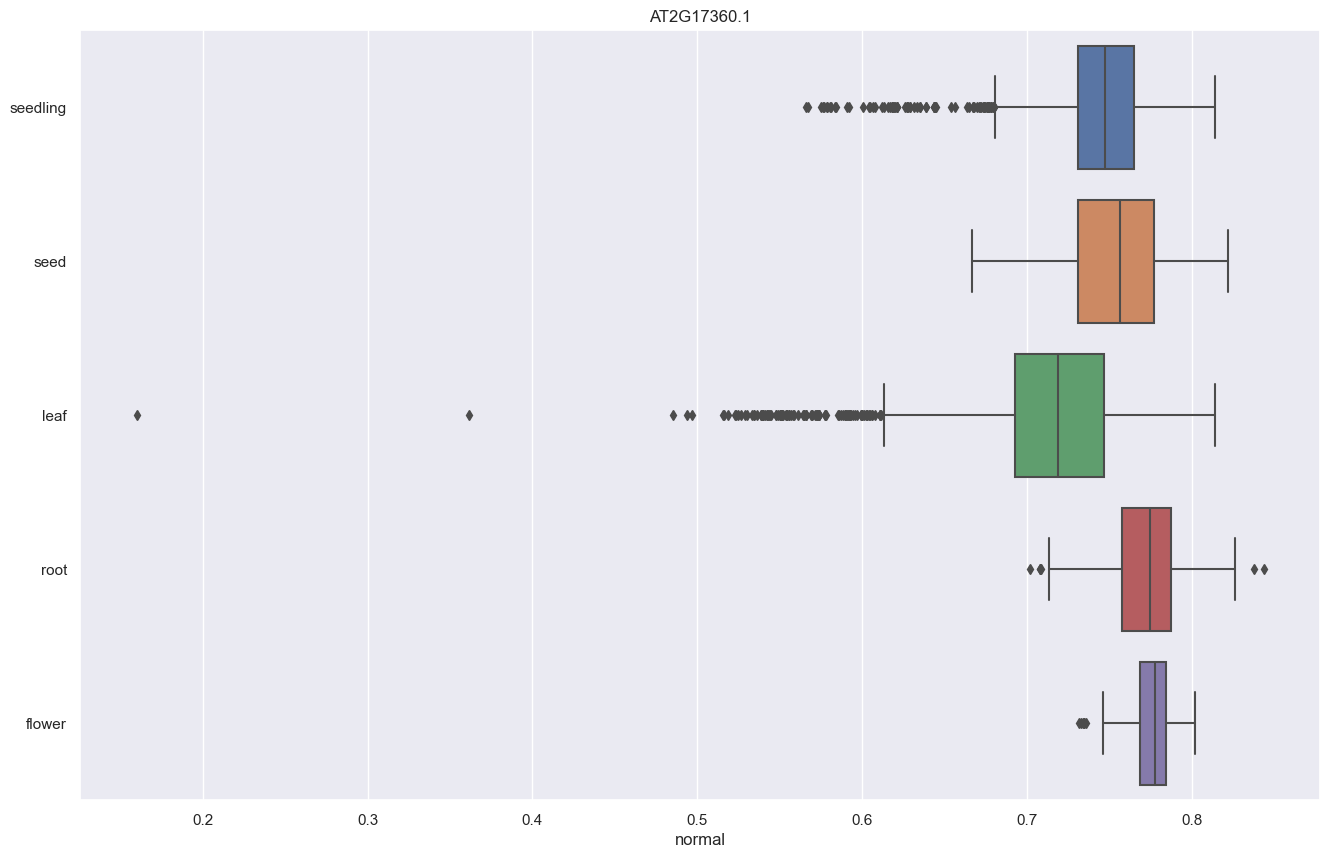

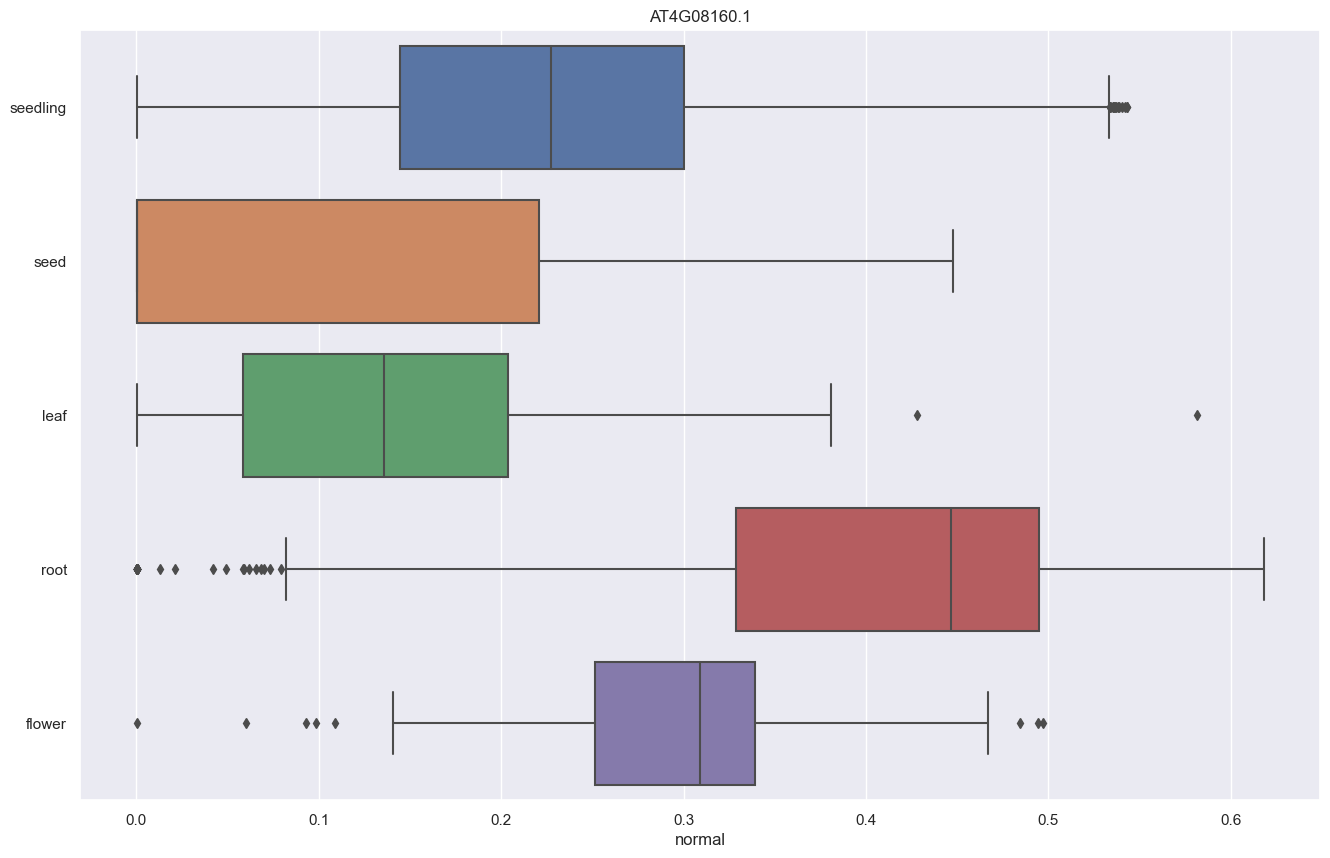

In [26]:
# Display an example of few gene expressions per tissue

for gene in genes :
	if gene not in anndata.var.index : continue

	data_anndata.gene_boxplot(
		data     = anndata,
		gene     = gene,
		groupby  = 'Tissue',
		layer    = 'normal',
		filename = os.path.join(OUT_PLOT, 'tissue-normal-' + gene)
	)

	matplotlib.pyplot.show()

# 6. Standard

In [27]:
# Compute and save the standardized tpm values

anndata, factors = data_anndata.compute_standardized(
	data       = anndata,
	layer      = mapping['standard'],
	store_into = 'standard',
	axis       = None
)

print('Mean : {}'.format(factors['mean']))
print(' Std : {}'.format(factors['std']))

Mean : 1.3591924898900338
 Std : 0.9386788414495827


In [28]:
# Save standardization factors

data_writer.write_json(
	data = factors,
	filename = os.path.join(OUT_DATA, 'factors-standard.json')
)

In [29]:
# Display anndata standardized tpm matrix information

data_anndata.show_matrix(anndata, layer = 'standard')

   Max value :   3.10279
  Mean value :   0.00000 ± 1.00000
Median value :   0.02051
   Min value :  -1.44798

Total elements        : 133,362,747
Total elements < -1.0 :  29,546,103 [ 22.15 %]
Total elements < -0.5 :  46,793,791 [ 35.09 %]
Total elements < -0.3 :  54,238,498 [ 40.67 %]
Total elements < -0.0 :  65,865,872 [ 49.39 %]
Total elements =  0.0 :           0 [  0.00 %]
Total elements >  0.0 :  67,496,875 [ 50.61 %]
Total elements >  0.3 :  55,228,854 [ 41.41 %]
Total elements >  0.5 :  46,622,586 [ 34.96 %]
Total elements >  1.0 :  24,798,127 [ 18.59 %]
Total elements >  2.0 :   1,855,234 [  1.39 %]

[[  0.858  -0.371   0.600  -1.448  -0.853  -0.828   0.404  -1.447   1.692  -0.010]
 [  0.907  -1.447   0.435  -0.066  -0.622  -0.552   0.474  -0.717   1.711  -0.598]
 [  1.132  -1.034   0.566  -1.447  -1.045  -0.927   0.633  -0.732   1.751   0.606]
 [  1.035  -0.580   0.654  -0.126  -1.447  -0.940   0.531  -1.236   1.761   0.373]
 [  1.116  -0.386   0.489  -0.959  -0.825  -0.553 

## 6.1 Distribution

Function : numpy.mean
Genes below 10th percentile [  -1.038686] :  3,271
Genes below 30th percentile [  -0.576097] :  9,813
Genes above 70th percentile [   0.502330] :  9,813
Genes above 90th percentile [   1.137426] :  3,271



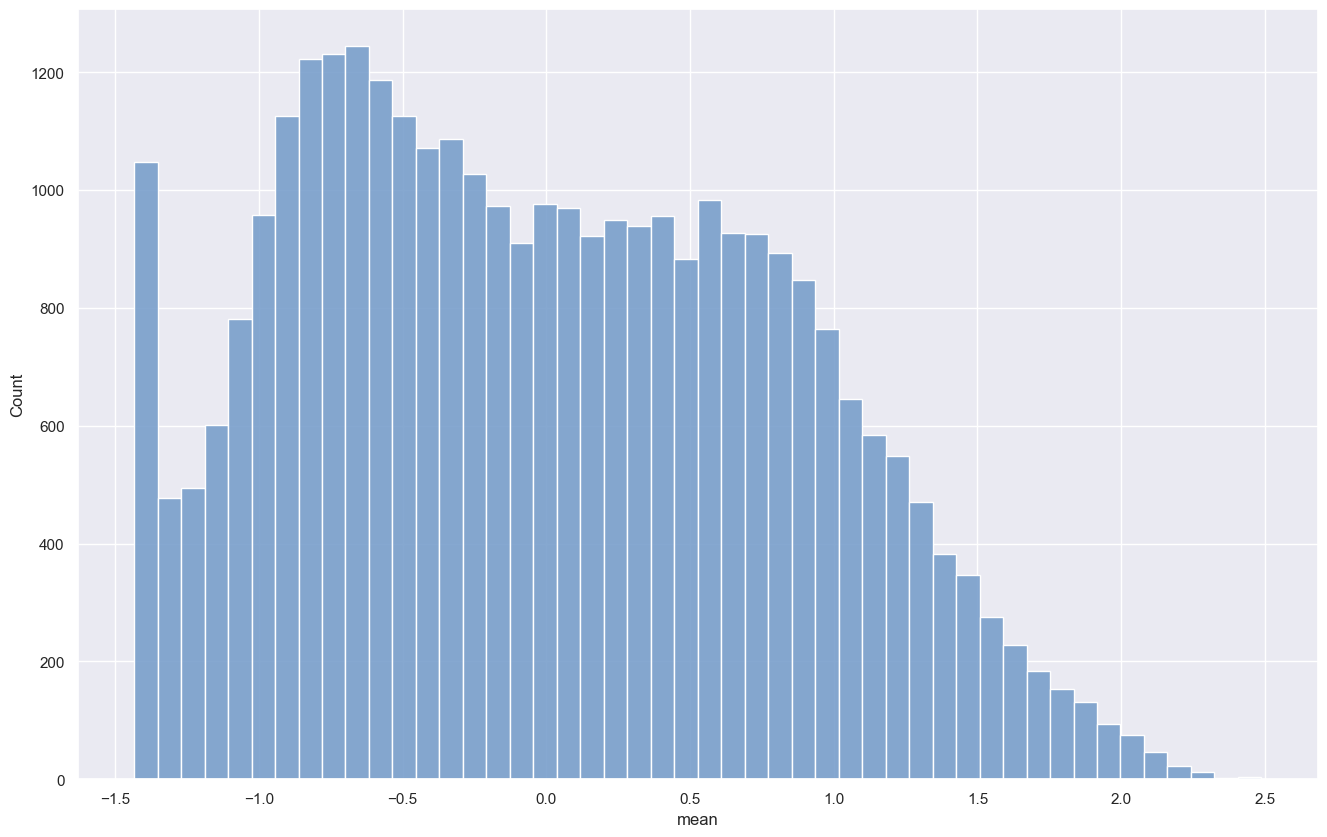

Function : __main__.percentile75
Genes below 10th percentile [  -0.820692] :  3,271
Genes below 30th percentile [  -0.150930] :  9,813
Genes above 70th percentile [   0.888974] :  9,813
Genes above 90th percentile [   1.447079] :  3,271



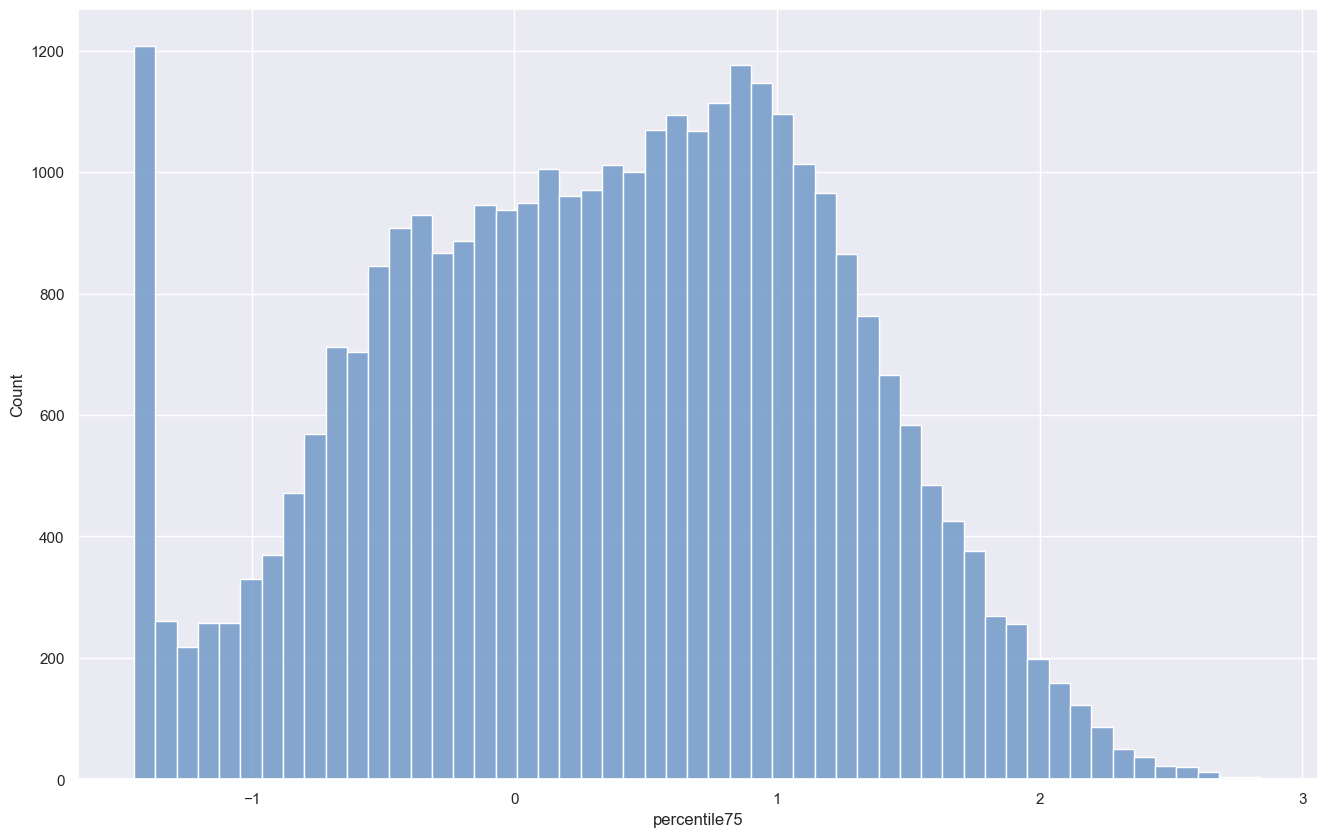

Function : numpy.amax
Genes below 10th percentile [   0.747159] :  3,271
Genes below 30th percentile [   1.219805] :  9,813
Genes above 70th percentile [   1.840062] :  9,813
Genes above 90th percentile [   2.259886] :  3,271



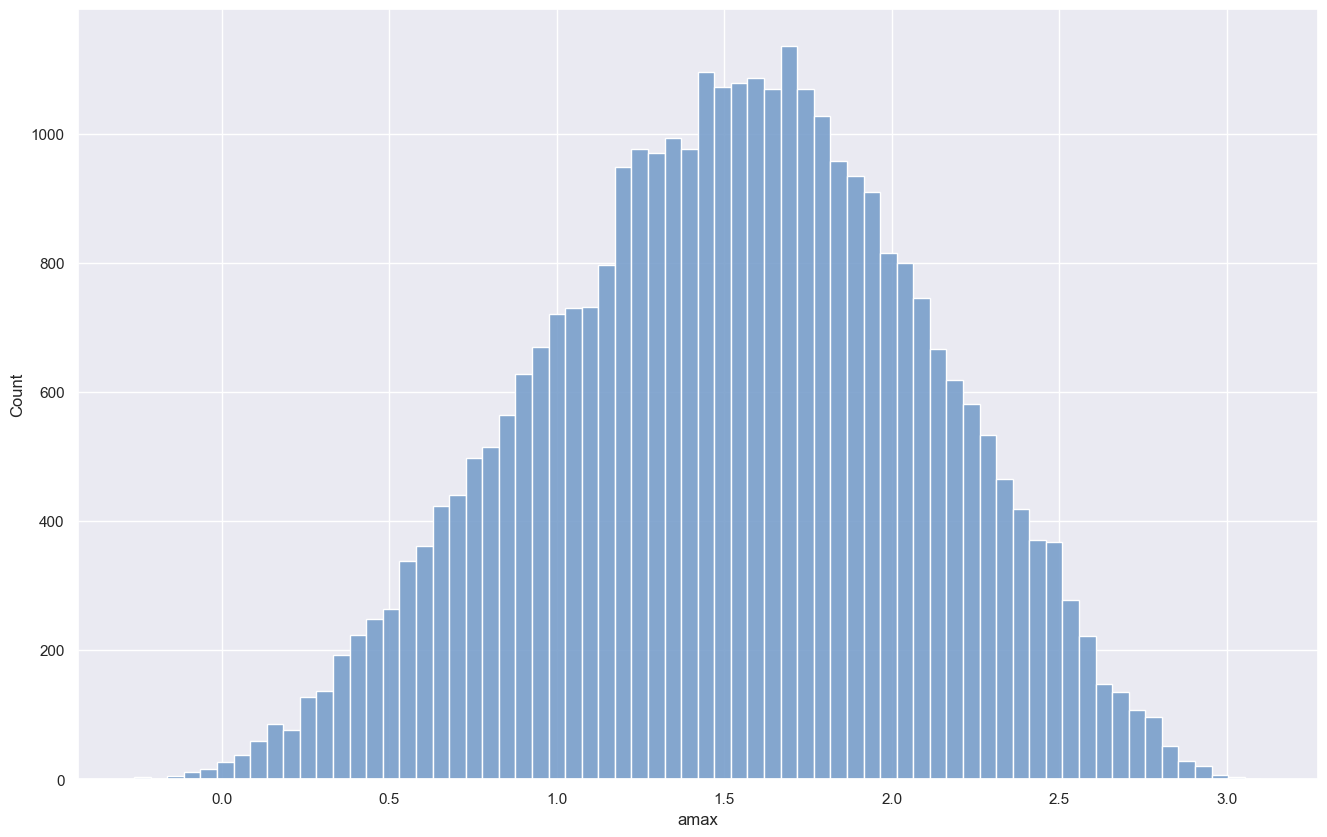

Function : numpy.std
Genes below 10th percentile [   0.295673] :  3,271
Genes below 30th percentile [   0.388326] :  9,813
Genes above 70th percentile [   0.590245] :  9,813
Genes above 90th percentile [   0.806545] :  3,271



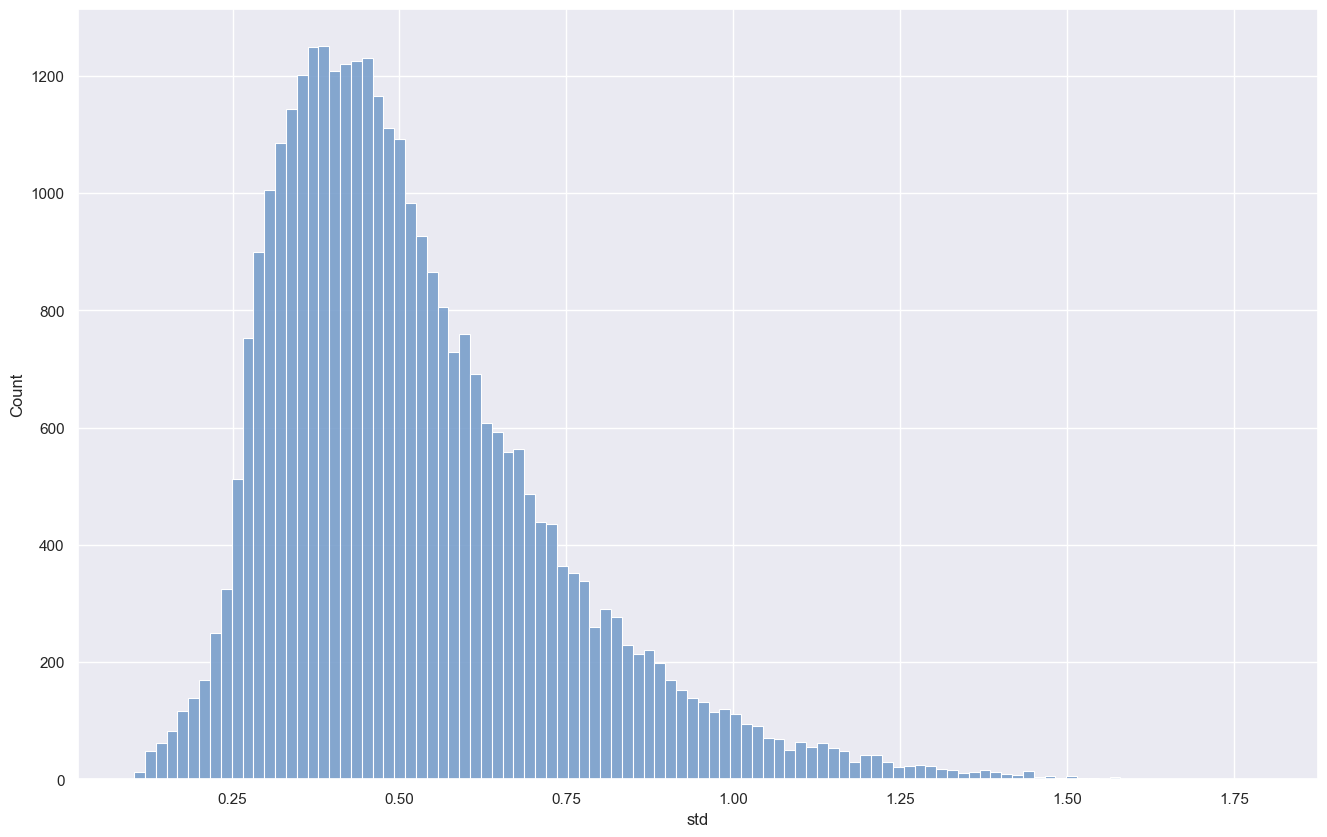

Function : numpy.amin
Genes below 10th percentile [  -1.447985] :  3,271
Genes below 30th percentile [  -1.447985] :  9,813
Genes above 70th percentile [  -1.446920] :  3,117
Genes above 90th percentile [  -1.446920] :  3,117



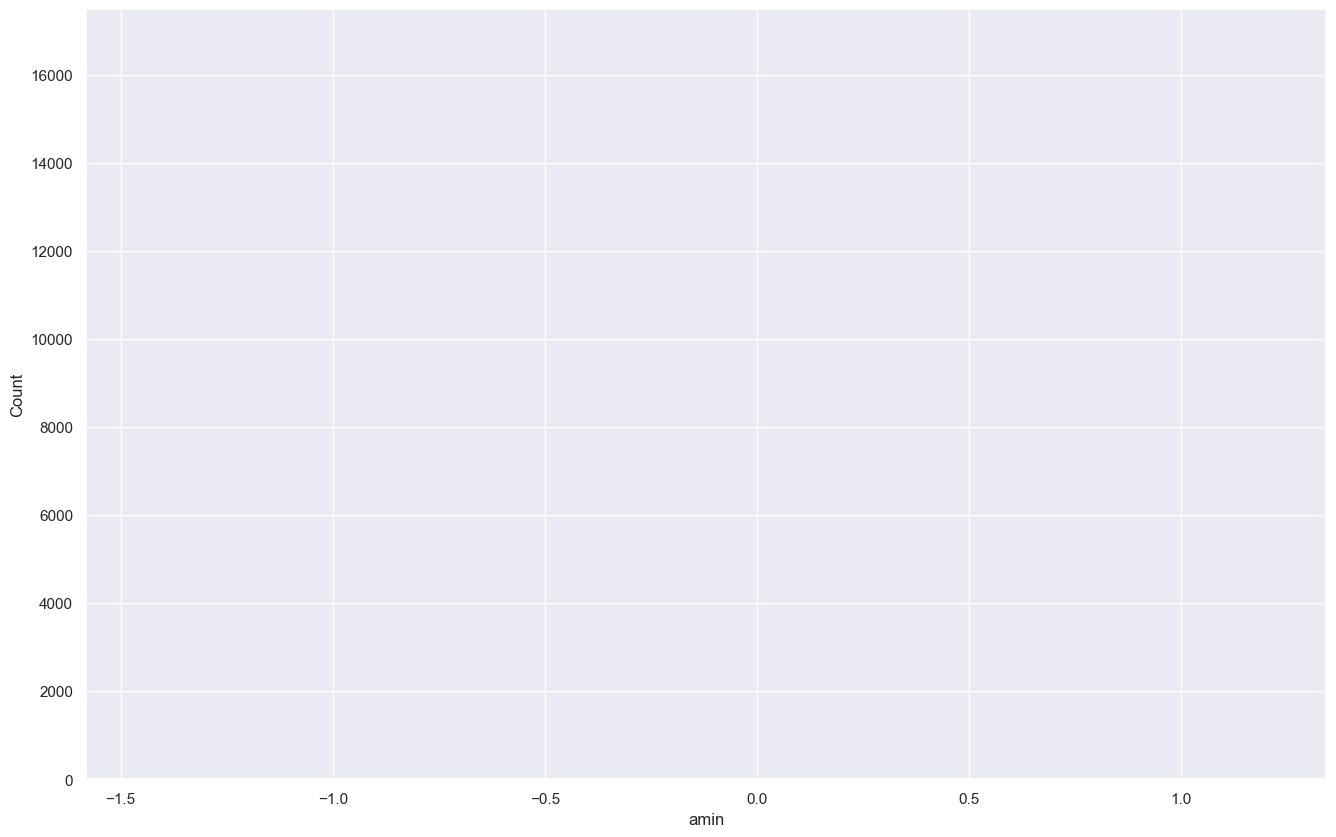

In [30]:
# Display standard tpm value distribution per gene

for name, function in functions :
	data_anndata.tpm_histplot(
		data     = anndata,
		layer    = 'standard',
		function = function,
		filters  = None,
		filename = os.path.join(OUT_PLOT, 'distribution-standard-' + name)
	)

	matplotlib.pyplot.show()

## 6.2 Genes

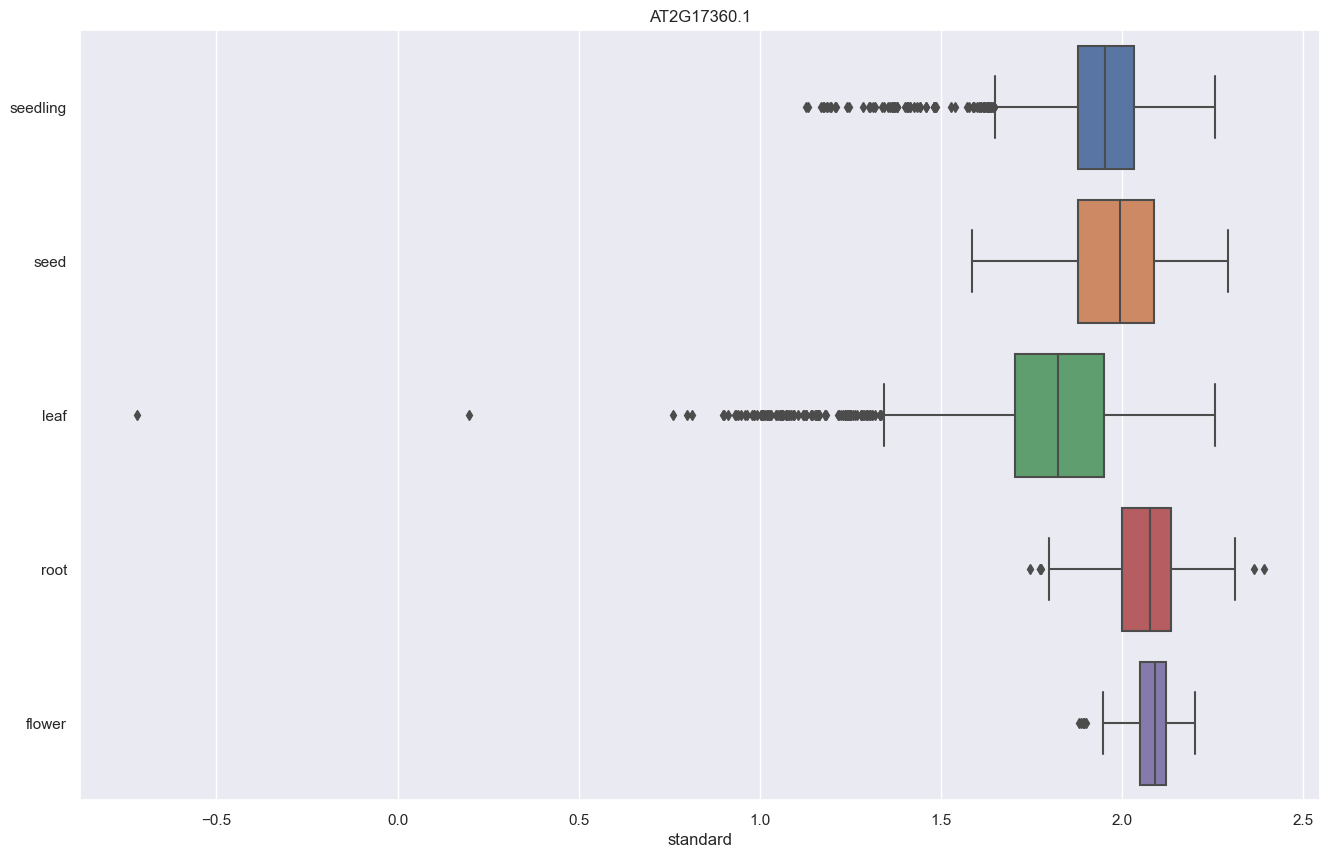

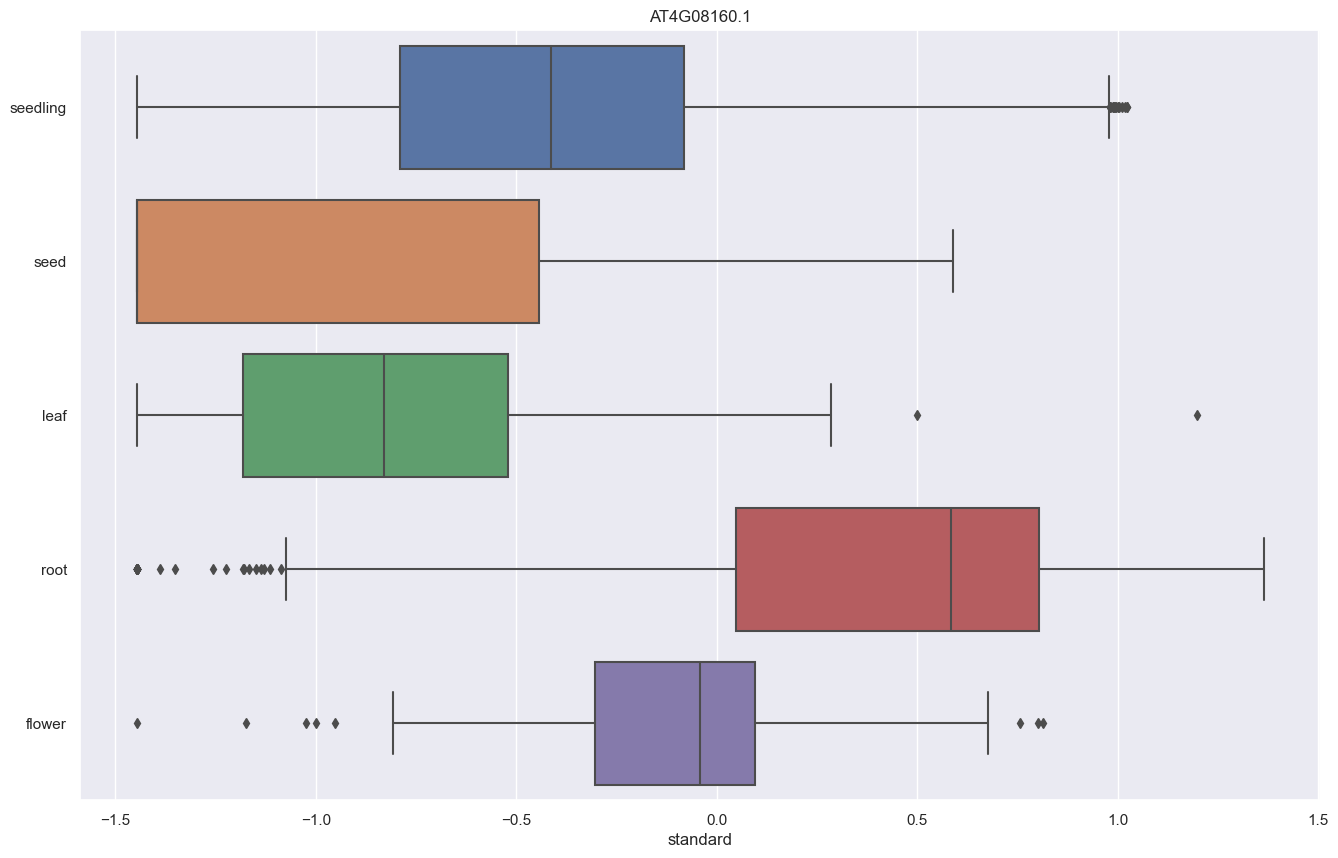

In [31]:
# Display an example of few gene expressions per tissue

for gene in genes :
	if gene not in anndata.var.index : continue

	data_anndata.gene_boxplot(
		data     = anndata,
		gene     = gene,
		groupby  = 'Tissue',
		layer    = 'standard',
		filename = os.path.join(OUT_PLOT, 'tissue-standard-' + gene)
	)

	matplotlib.pyplot.show()

# 7. Save

In [32]:
# Save the annotated data with multiple layers

data_writer.write_h5ad(
	data     = anndata,
	filename = os.path.join(OUT_DATA, 'arabidopsis-r36.h5ad')
)